# Processed Flight Samples 

Sampled from over last year. 

##  Loading in the Flight Data

In [1]:
import glob
import dask.dataframe as dd
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Use a cleaner style and increase font sizes
sns.set_style('whitegrid')
sns.set_context('notebook')


In [3]:
flight_chunk_paths = glob.glob("../../data/processed/global_flights/v4_samples_chunk_*.parquet")

# Read parquet files using dask
flight_data = dd.read_parquet(flight_chunk_paths[:1])

# lets take a smaller sammple 
sample_flights = flight_data.sample(frac=0.2).compute()

# info on the sample flights
sample_flights.info()


<class 'pandas.core.frame.DataFrame'>
Index: 9925 entries, 21970 to 29728
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   icao24               9925 non-null   string        
 1   callsign             9910 non-null   string        
 2   estdepartureairport  7847 non-null   string        
 3   estarrivalairport    8422 non-null   string        
 4   firstseen            9925 non-null   int64[pyarrow]
 5   lastseen             9925 non-null   int64[pyarrow]
 6   track                9925 non-null   object        
 7   time_min             9925 non-null   float64       
 8   time_max             9925 non-null   float64       
 9   time_avg             9925 non-null   float64       
 10  start_time           9925 non-null   datetime64[ns]
 11  end_time             9925 non-null   datetime64[ns]
 12  latitude_min         9925 non-null   float64       
 13  latitude_max         9925 non-nul

In [4]:
sample_flights.dtypes

icao24                 string[pyarrow]
callsign               string[pyarrow]
estdepartureairport    string[pyarrow]
estarrivalairport      string[pyarrow]
firstseen               int64[pyarrow]
lastseen                int64[pyarrow]
track                           object
time_min                       float64
time_max                       float64
time_avg                       float64
start_time              datetime64[ns]
end_time                datetime64[ns]
latitude_min                   float64
latitude_max                   float64
latitude_avg                   float64
longitude_min                  float64
longitude_max                  float64
longitude_avg                  float64
altitude_min                   float64
altitude_max                   float64
altitude_avg                   float64
heading_min                    float64
heading_max                    float64
heading_avg                    float64
onground_percentage            float64
dtype: object

Overview of the flights data 

Tracks flight trajectories and airport estimates, including ICAO24 identifiers, first/last seen timestamps, departure/arrival airport candidates, and a track array storing positional waypoints (time, latitude, longitude). Metricsa like horizontal/vertical distances to estimated airports and candidate airport lists are included. Partitioned by day.

The processed data adds the following columns:
- start_time: datetime64[ms]
- end_time: datetime64[ms]
- latitude_min: float64
- latitude_max: float64
- longitude_min: float64
- longitude_max: float64
- altitude_min: float64
- altitude_max: float64
- heading_min: float64
- heading_max: float64
- onground_percentage: float

## 1. Data Quality and Basic Distributions

### Missing Values & Data Completeness

- Check how many records have missing or null values in each column (e.g., missing estarrivalairport or callsign values).
Visualize with a heatmap of missingness or a bar chart showing percentage missing per column.

<Figure size 1000x600 with 0 Axes>

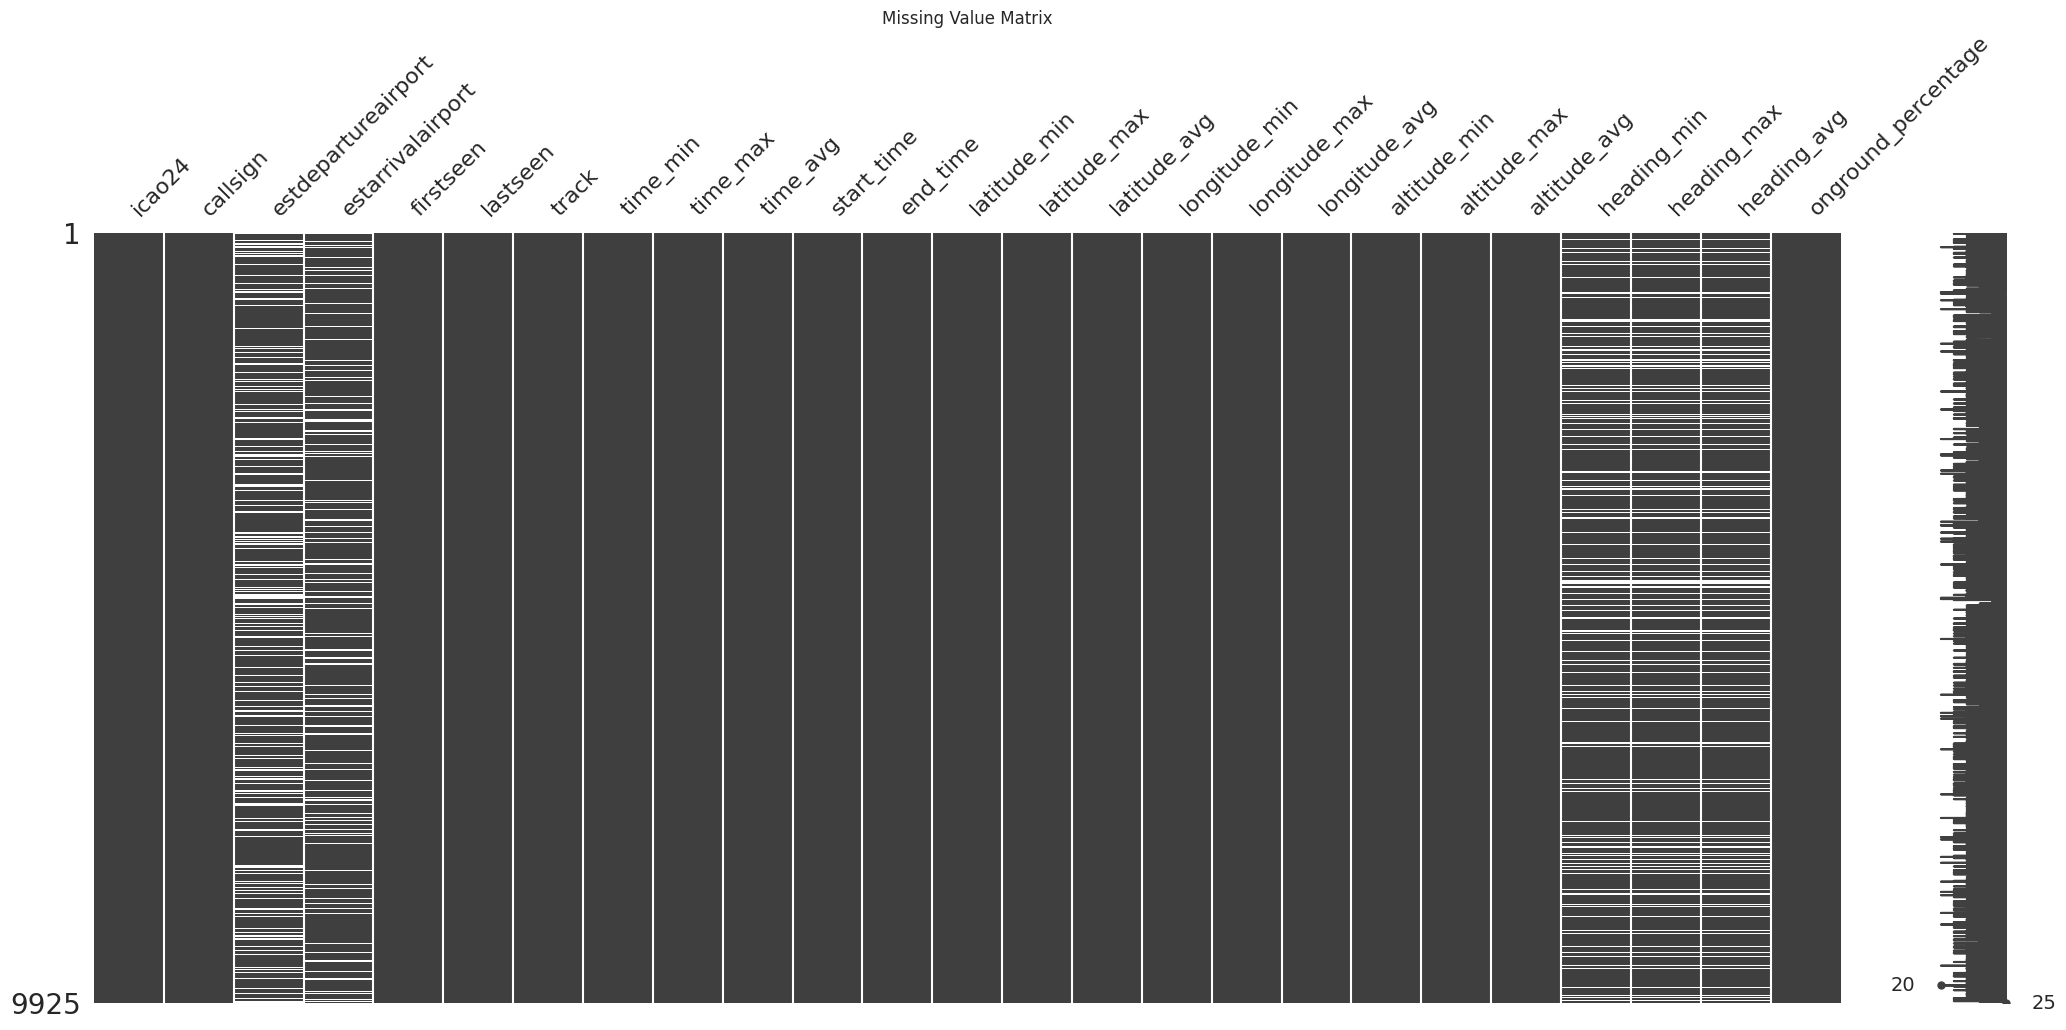

<Figure size 1000x600 with 0 Axes>

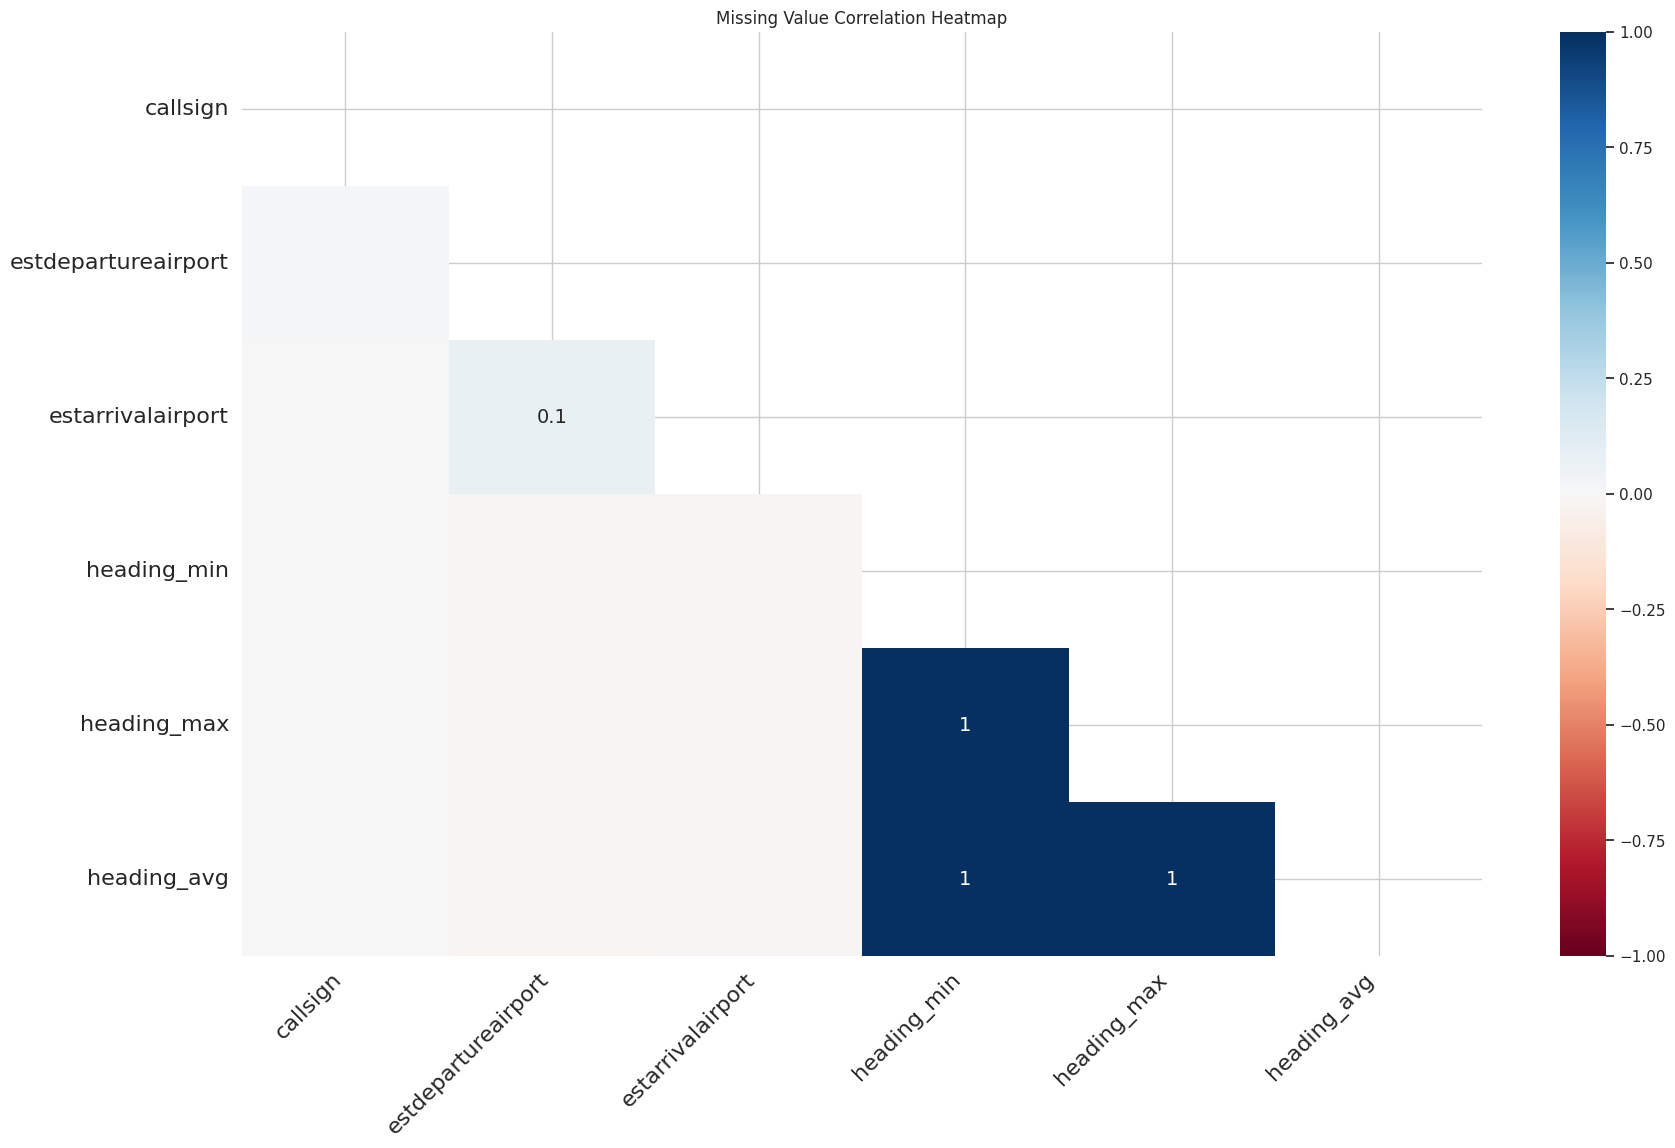


Percentage of missing values per column:
estdepartureairport    20.937028
estarrivalairport      15.143577
heading_max            12.372796
heading_min            12.372796
heading_avg            12.372796
callsign                0.151134
lastseen                0.000000
icao24                  0.000000
firstseen               0.000000
time_max                0.000000
time_min                0.000000
track                   0.000000
time_avg                0.000000
latitude_max            0.000000
start_time              0.000000
end_time                0.000000
latitude_min            0.000000
longitude_max           0.000000
longitude_min           0.000000
latitude_avg            0.000000
longitude_avg           0.000000
altitude_avg            0.000000
altitude_max            0.000000
altitude_min            0.000000
onground_percentage     0.000000
dtype: float64


In [5]:
# Set figure size for better visibility
plt.figure(figsize=(10, 6))

# Create a matrix visualization of missing values
msno.matrix(sample_flights)
plt.title('Missing Value Matrix')
plt.show()

# Create a heatmap/correlation of missingness
plt.figure(figsize=(10, 6))
msno.heatmap(sample_flights)
plt.title('Missing Value Correlation Heatmap') 
plt.show()

# Print percentage of missing values per column
missing_percentages = (sample_flights.isnull().sum() / len(sample_flights)) * 100
print("\nPercentage of missing values per column:")
print(missing_percentages.sort_values(ascending=False))


We can notice that the estimated departure and arrival airports are missing for a lot ofthe flights around 15-21%. Other missing columns are of the heading feature and the callsign feature.

### Basic Statistical Distribution

- Histograms / Distribution Plots for numeric columns like latitude_min, latitude_max, altitude_avg, heading_avg, onground_percentage, etc.
- Boxplots to quickly spot outliers (altitudes, headings).

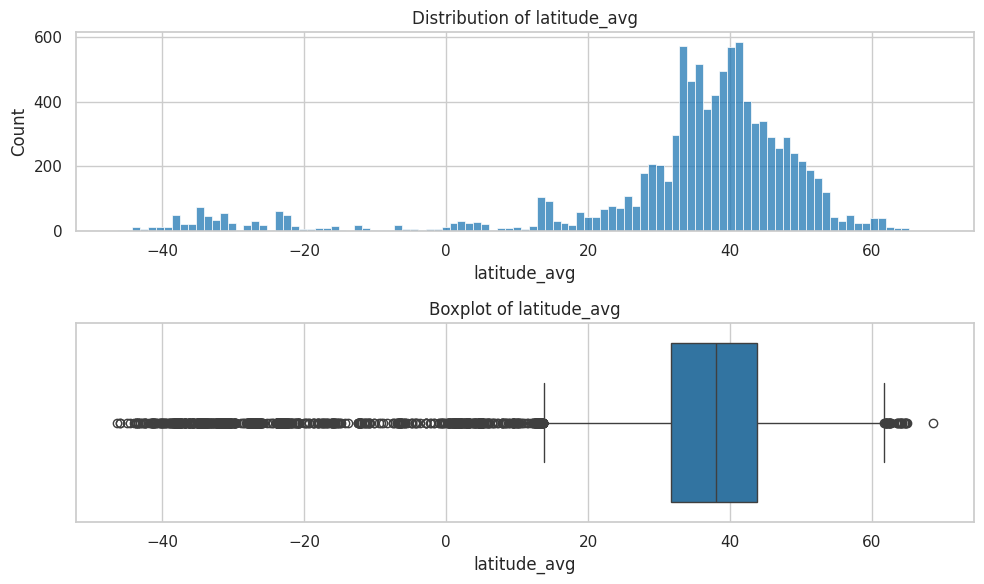

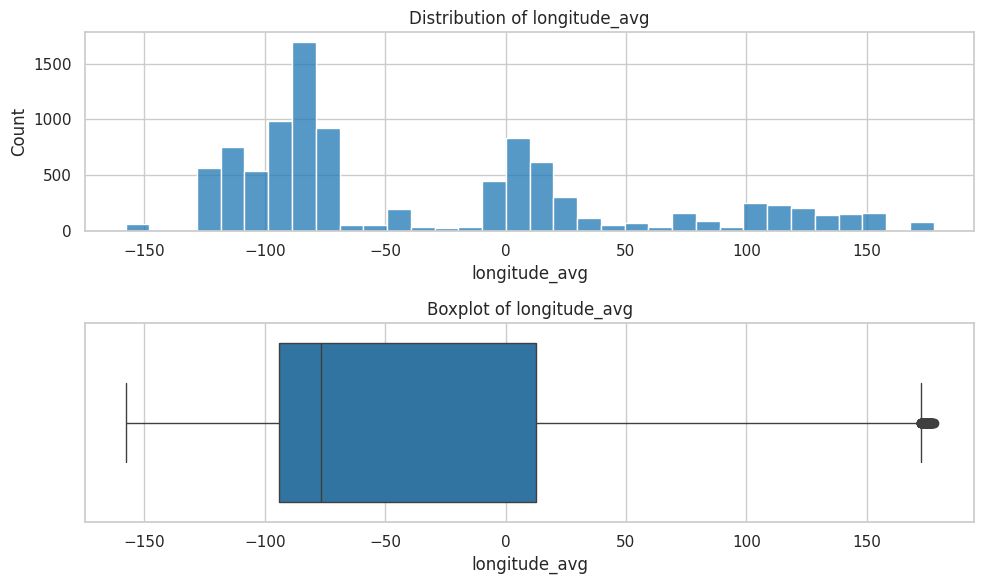

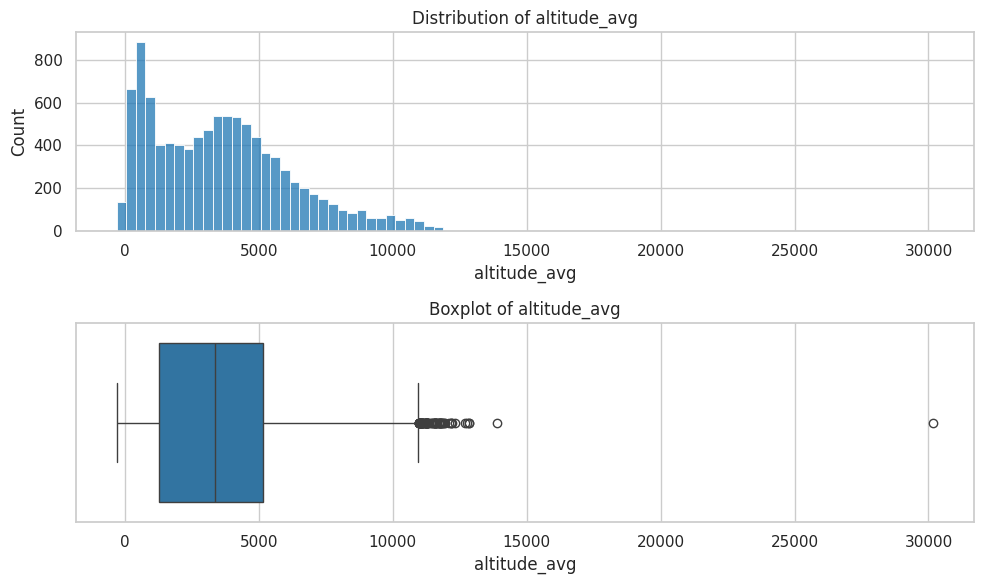

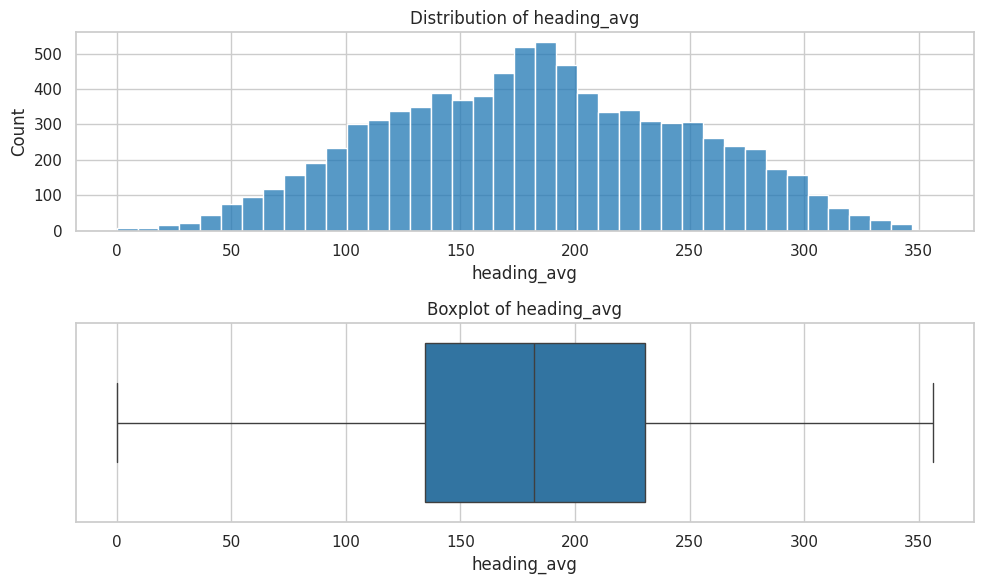

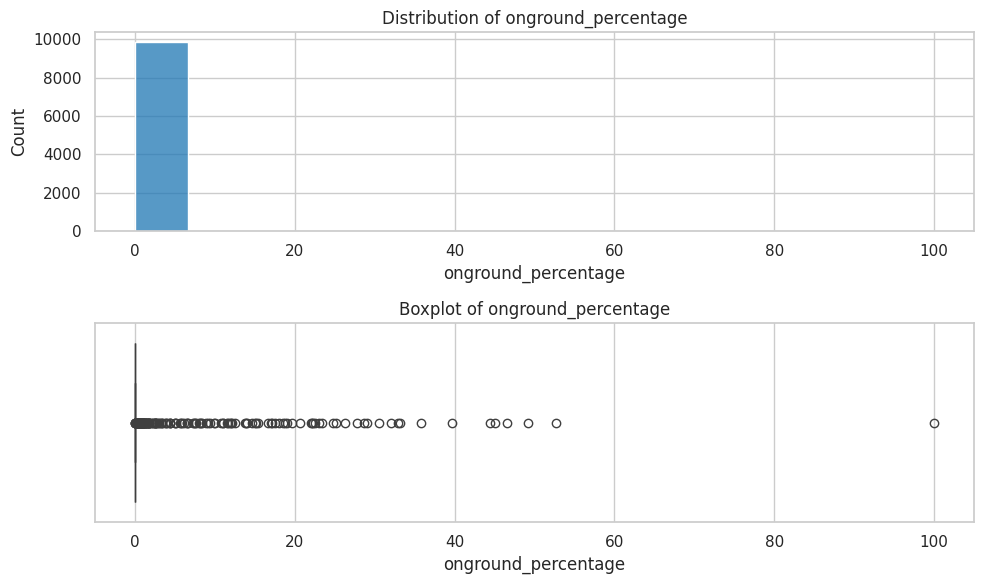

In [6]:
def plot_distribution(data, column, title, figsize=(10,6)):
    """
    Create histogram and boxplot for a given column.
    
    Args:
        data: DataFrame containing the data
        column: Column name to plot
        title: Title for the plots
        figsize: Figure size tuple, default (10,6)
    """
    # Create figure with 2 subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize)
    
    # Histogram
    sns.histplot(data=data, x=column, ax=ax1)
    ax1.set_title(f'Distribution of {title}')
    ax1.set_xlabel(column)
    ax1.set_ylabel('Count')
    
    # Boxplot
    sns.boxplot(data=data, x=column, ax=ax2)
    ax2.set_title(f'Boxplot of {title}')
    ax2.set_xlabel(column)
    
    plt.tight_layout()
    plt.show()

# Plot distributions for key numeric columns
numeric_cols = ['latitude_avg', 'longitude_avg', 'altitude_avg', 
                'heading_avg', 'onground_percentage']

for col in numeric_cols:
    plot_distribution(sample_flights, col, col)


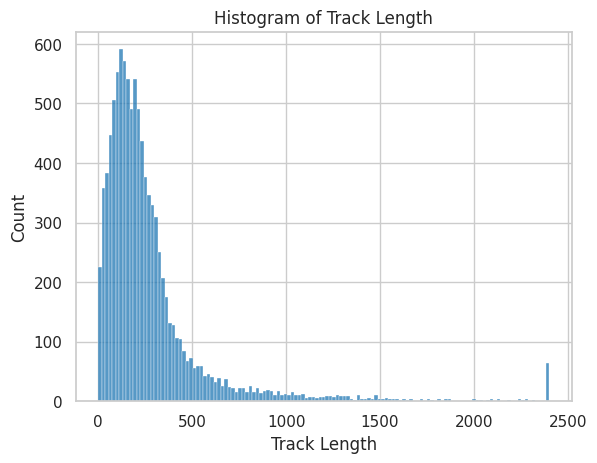

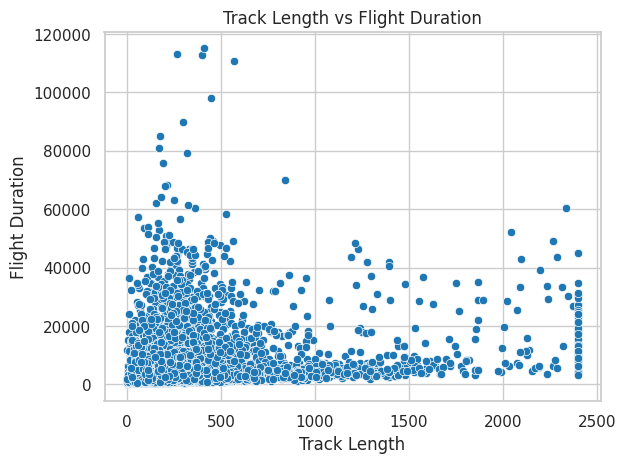

In [7]:
# histogram of length of track array (how does it correlate to how long the flight is?)

sample_flights['track_length'] = sample_flights['track'].apply(len)
sns.histplot(sample_flights['track_length'])
plt.title('Histogram of Track Length')
plt.xlabel('Track Length')
plt.ylabel('Count')
plt.show()

sample_flights['flight_duration'] = (sample_flights['time_max'] - sample_flights['time_min'])
# plot the track length vs the flight duration
sns.scatterplot(x='track_length', y='flight_duration', data=sample_flights)
plt.title('Track Length vs Flight Duration')
plt.xlabel('Track Length')
plt.ylabel('Flight Duration')
plt.show()

### Outlier Detection

- Identify extreme latitude/longitude values (possible data errors if beyond valid coordinate ranges).
- Check for negative altitudes (or extremely high altitudes).
- Look for unusual timestamps (e.g., time_min that is after time_max, or flights with negative duration).


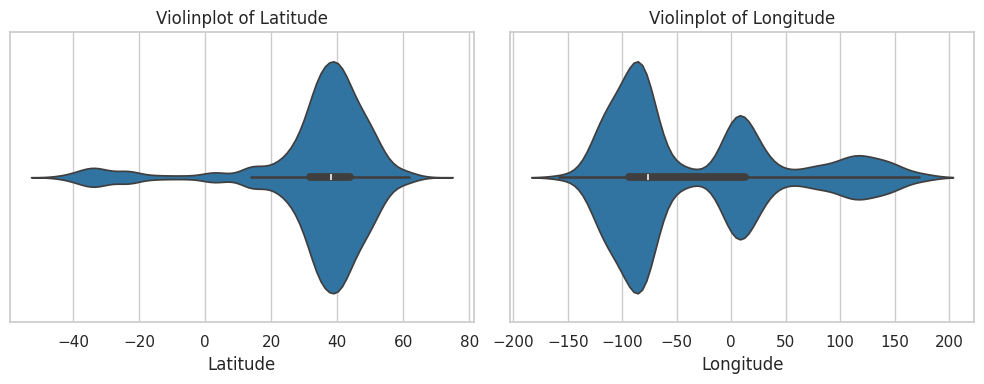

In [8]:
# lets look if there are any outliers in the latitude and longitude
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

sns.violinplot(x='latitude_avg', data=sample_flights, ax=ax1)
ax1.set_title('Violinplot of Latitude')
ax1.set_xlabel('Latitude')

sns.violinplot(x='longitude_avg', data=sample_flights, ax=ax2)
ax2.set_title('Violinplot of Longitude') 
ax2.set_xlabel('Longitude')

plt.tight_layout()
plt.show()


The violin plots illustrate the distribution of average latitude and longitude values for a sample of global flights from the OpenSky historical ADS-B database. 

The latitude distribution is centered around 30-40 degrees, indicating a high density of flights in the Northern Hemisphere, while extreme latitudes see less activity due to fewer commercial routes. The longitude distribution shows multiple peaks, suggesting that air traffic is concentrated in key corridors, particularly between -150 to -50 degrees (North America and transatlantic routes) and 0 to 50 degrees (Europe and Africa). The asymmetry in longitude distribution highlights major airline hubs and constrained airspace regions. 

Overall, the plots reveal that global flight patterns are not uniform but instead concentrated around major economic and aviation hubs. Further analysis could involve mapping these distributions onto a world map, analyzing seasonal variations, clustering flights by region, and examining altitude distributions to gain deeper insights into air traffic patterns.


In [9]:
# are there any flights with negative duration?
sample_flights[sample_flights['flight_duration'] < 0]

print(f"Number of flights with negative duration: {len(sample_flights[sample_flights['flight_duration'] < 0])}")


Number of flights with negative duration: 0


### Timestamp Validation

- Ensure firstseen < lastseen < time_max etc.
- Convert timestamps to local times or use them to derive features (day vs. night flights).

Flights where firstseen > lastseen: 0
Flights where lastseen > time_max: 9920


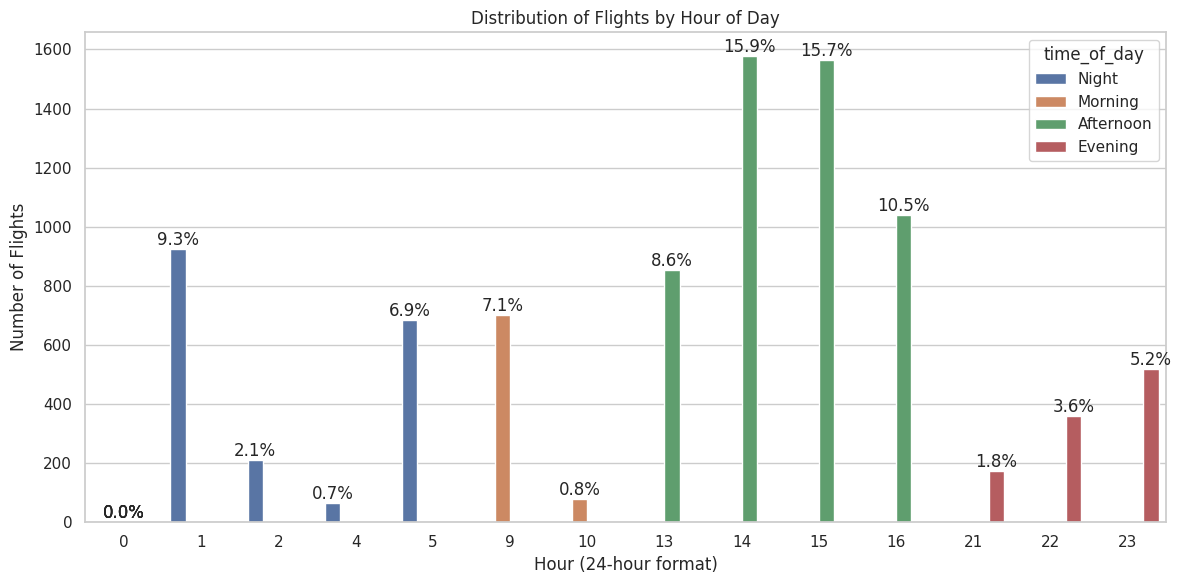

In [10]:
# Check for timestamp inconsistencies
invalid_firstseen_lastseen = sample_flights[sample_flights['firstseen'] > sample_flights['lastseen']]
invalid_lastseen_timemax = sample_flights[sample_flights['lastseen'] > sample_flights['time_max']]

print(f"Flights where firstseen > lastseen: {len(invalid_firstseen_lastseen)}")
print(f"Flights where lastseen > time_max: {len(invalid_lastseen_timemax)}")

# Convert timestamps to local time and categorize flights
sample_flights['local_time'] = pd.to_datetime(sample_flights['time_min'], unit='s').dt.tz_localize('UTC')
sample_flights['hour'] = sample_flights['local_time'].dt.hour
sample_flights['time_of_day'] = pd.cut(sample_flights['hour'], 
                                     bins=[0, 6, 12, 18, 24],
                                     labels=['Night', 'Morning', 'Afternoon', 'Evening'])

# Create a more informative plot
plt.figure(figsize=(12, 6))
sns.countplot(data=sample_flights, x='hour', hue='time_of_day', palette='deep')
plt.title('Distribution of Flights by Hour of Day')
plt.xlabel('Hour (24-hour format)')
plt.ylabel('Number of Flights')

# Add percentage labels on top of bars
total = len(sample_flights)
for p in plt.gca().patches:
    percentage = f'{100 * p.get_height() / total:.1f}%'
    x = p.get_x() + p.get_width()/2
    y = p.get_height()
    plt.gca().annotate(percentage, (x, y), ha='center', va='bottom')

plt.tight_layout()
plt.show()

## 2. Summary Statistics


### Flight Count Per Airport

- Group by estdepartureairport or estarrivalairport and count the number of flights.
- Identify the busiest airports (top 10 departure/arrival).

Top 10 Departure Airports by Flight Count:
estdepartureairport
KORD    109
KATL     94
KDEN     86
KDFW     85
KCLT     76
KEWR     64
KLAX     60
KLAS     60
EHAM     59
KPHX     58
Name: count, dtype: int64[pyarrow]

Top 10 Arrival Airports by Flight Count:
estarrivalairport
KATL    81
KLAX    80
KORD    77
KLAS    72
KDEN    70
EHAM    62
KBOS    60
KDFW    59
LFPG    59
LTFM    55
Name: count, dtype: int64[pyarrow]


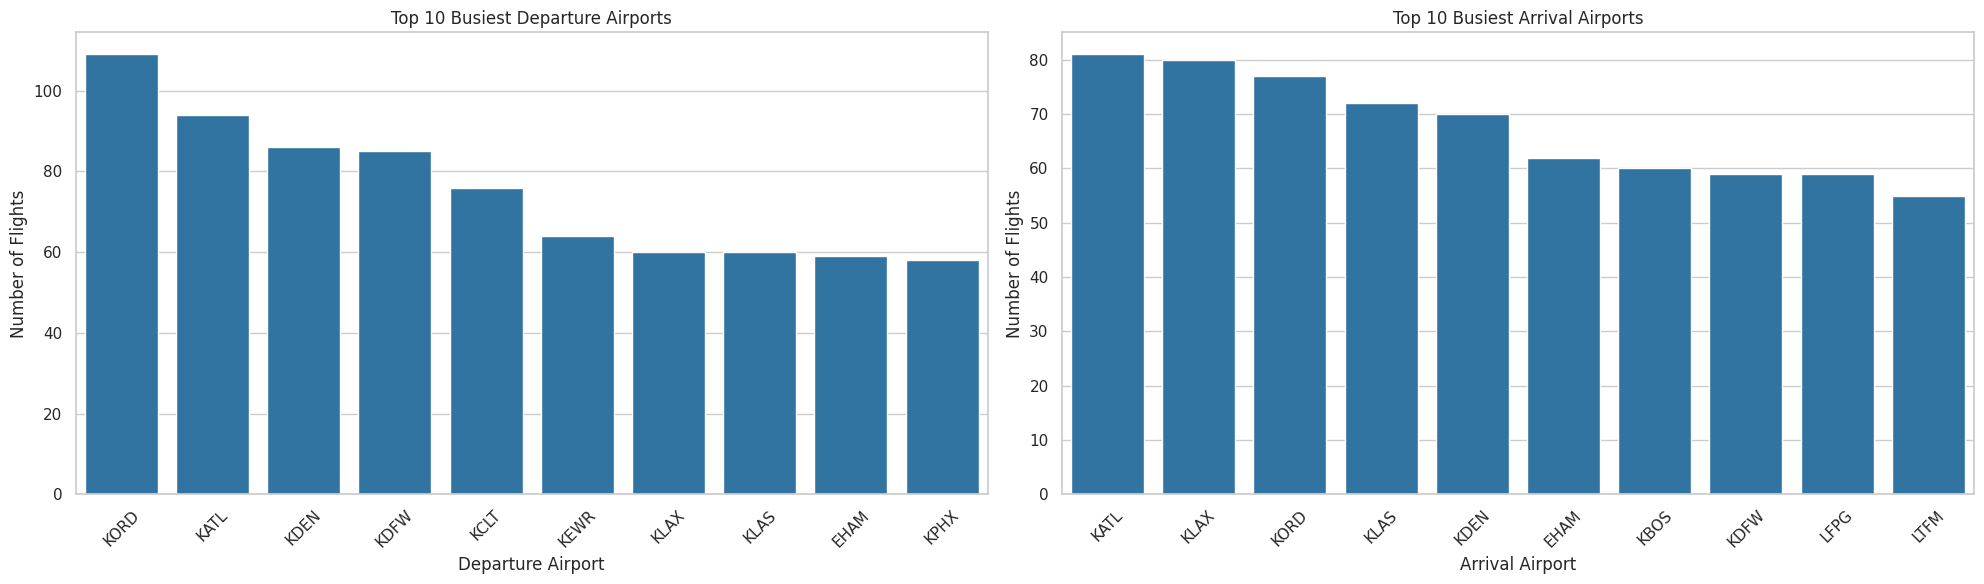

In [11]:
# Flight Count Per Airport

# Count flights by departure airport and select top 10
dep_airport_counts = sample_flights['estdepartureairport'].value_counts().head(10)
print("Top 10 Departure Airports by Flight Count:")
print(dep_airport_counts)

# Count flights by arrival airport and select top 10
arr_airport_counts = sample_flights['estarrivalairport'].value_counts().head(10)
print("\nTop 10 Arrival Airports by Flight Count:")
print(arr_airport_counts)

# Create side-by-side subplots for the two plots
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Plot the top 10 departure airports on the left subplot
sns.barplot(ax=axes[0], x=dep_airport_counts.index, y=dep_airport_counts.values)
axes[0].set_title('Top 10 Busiest Departure Airports')
axes[0].set_xlabel('Departure Airport')
axes[0].set_ylabel('Number of Flights')
axes[0].tick_params(axis='x', rotation=45)

# Plot the top 10 arrival airports on the right subplot
sns.barplot(ax=axes[1], x=arr_airport_counts.index, y=arr_airport_counts.values)
axes[1].set_title('Top 10 Busiest Arrival Airports')
axes[1].set_xlabel('Arrival Airport')
axes[1].set_ylabel('Number of Flights')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### Flight Duration / Time On Ground

- If you have flight duration (e.g. lastseen - firstseen), examine the distribution of durations.
- Compare durations from specific origin airports to specific destination airports.

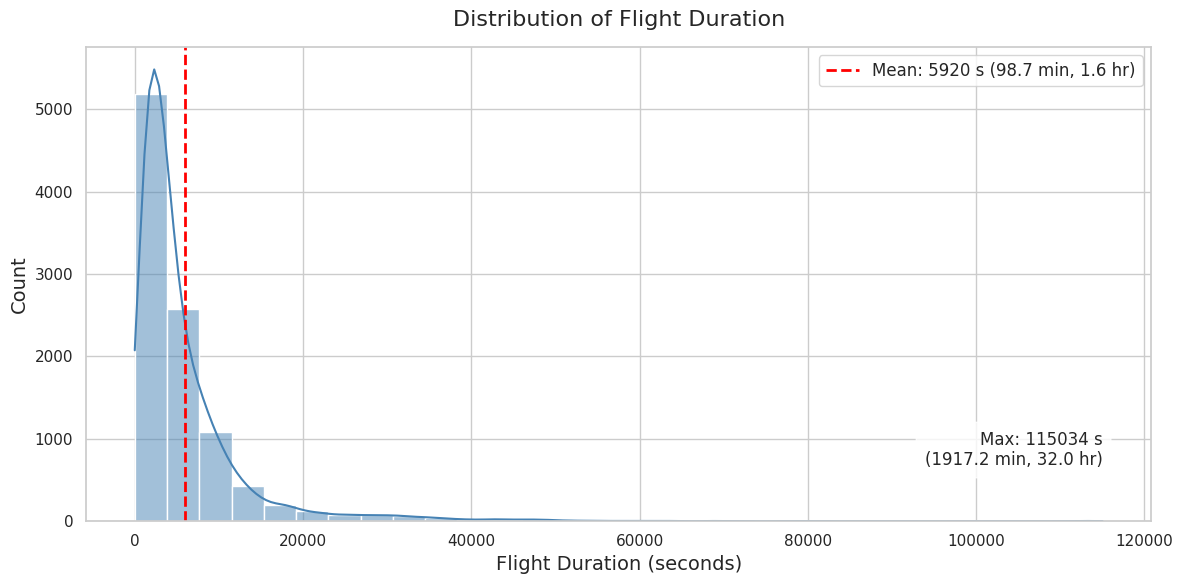

In [12]:
# Compute stats
mean_duration = sample_flights['flight_duration'].mean()
max_duration = sample_flights['flight_duration'].max()

# Create figure and histogram
plt.figure(figsize=(12, 6))
sns.histplot(sample_flights['flight_duration'], bins=30, kde=True, color='steelblue')

# Title and axis labels
plt.title('Distribution of Flight Duration', fontsize=16, pad=15)
plt.xlabel('Flight Duration (seconds)', fontsize=14)
plt.ylabel('Count', fontsize=14)

# Add vertical line for the mean
plt.axvline(mean_duration, color='red', linestyle='--', linewidth=2,
            label=f'Mean: {mean_duration:.0f} s '
                  f'({mean_duration/60:.1f} min, {mean_duration/3600:.1f} hr)')

# -- Compute the histogram so we know where to place the max annotation --
counts, bin_edges = np.histogram(sample_flights['flight_duration'], bins=30)
# Find which bin the max value is in:
max_bin_index = np.searchsorted(bin_edges, max_duration, side='right') - 2
# The height of that bin:
max_bin_height = counts[max_bin_index] if max_bin_index >= 0 else 0

# Annotate the maximum
plt.annotate(
    text=(
        f'Max: {max_duration:.0f} s\n'
        f'({max_duration/60:.1f} min, {max_duration/3600:.1f} hr)'
    ),
    xy=(max_duration, max_bin_height),
    xytext=(0, 40),  # Offset in points (x, y)
    textcoords='offset points',
    ha='right',
    arrowprops=dict(arrowstyle='->', 
                    connectionstyle='angle3,angleA=0,angleB=90'),
    bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.8)
)

# Show legend, tighten layout
plt.legend(loc='upper right', fontsize=12)
plt.tight_layout()
plt.show()

In [13]:
# Get longest flight duration and convert to minutes/hours
longest_duration = sample_flights['flight_duration'].max()
print(f"Longest flight duration:")
print(f"  {longest_duration:.0f} seconds")
print(f"  {longest_duration/60:.1f} minutes") 
print(f"  {longest_duration/3600:.1f} hours")

Longest flight duration:
  115034 seconds
  1917.2 minutes
  32.0 hours


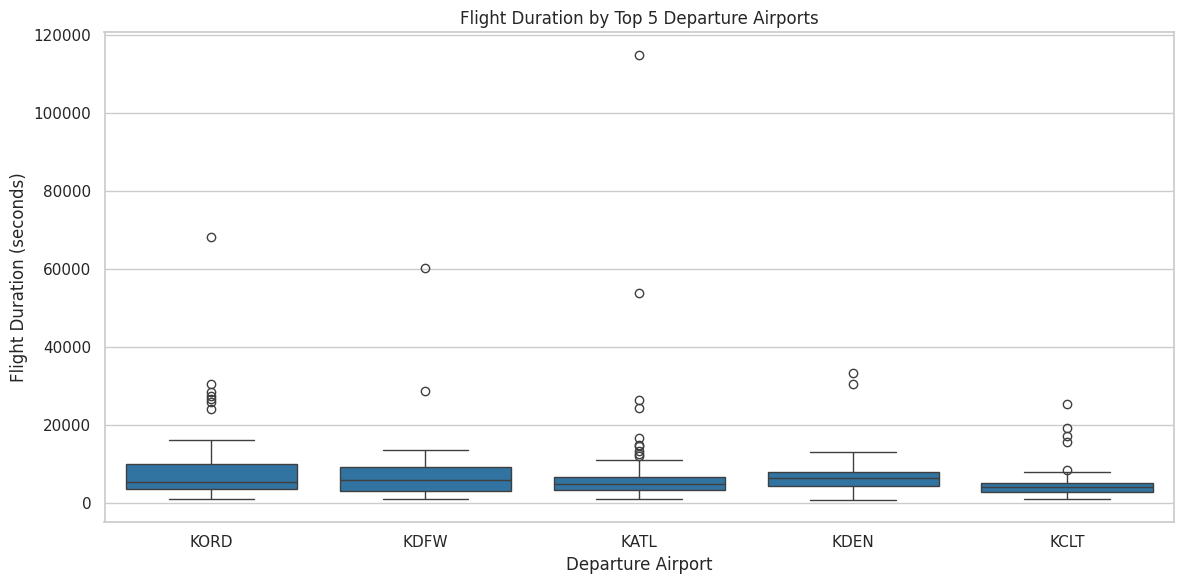

In [14]:
# Identify top 5 departure airports by flight count
top_dep_airports = sample_flights['estdepartureairport'].value_counts().head(5).index.tolist()

# Filter data for these top departure airports
filtered_dep = sample_flights[sample_flights['estdepartureairport'].isin(top_dep_airports)]

# Boxplot of flight duration per departure airport
plt.figure(figsize=(12, 6))
sns.boxplot(x='estdepartureairport', y='flight_duration', data=filtered_dep)
plt.title('Flight Duration by Top 5 Departure Airports')
plt.xlabel('Departure Airport')
plt.ylabel('Flight Duration (seconds)')
plt.tight_layout()
plt.show()

### Altitude & Heading Ranges

- Compare altitude_min vs. altitude_max across different callsigns or airports.
- Look at common flight headings by region.

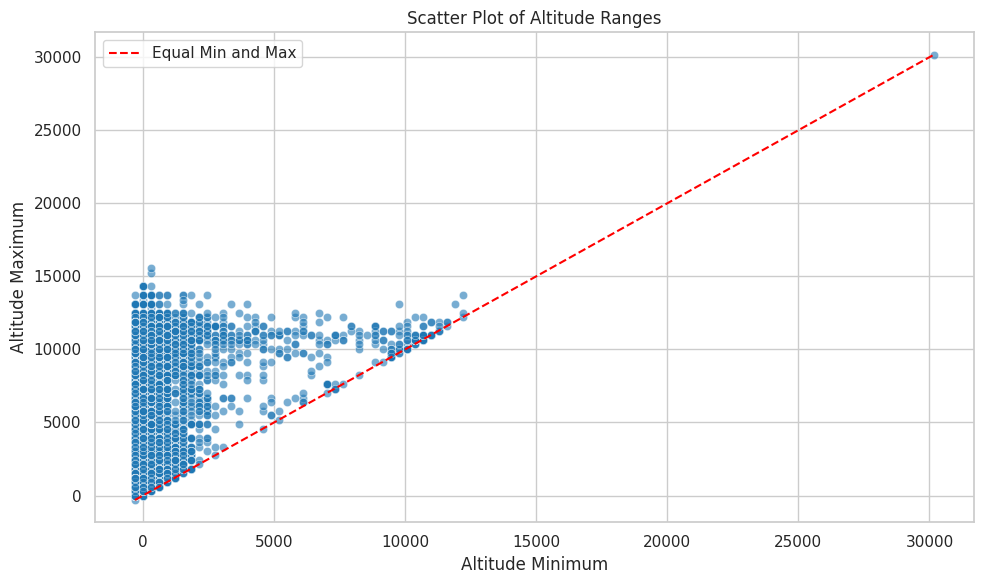

In [15]:
# Altitude Ranges: Scatter Plot of altitude_min vs altitude_max

# Drop rows with missing altitude values
altitude_data = sample_flights.dropna(subset=['altitude_min', 'altitude_max'])

plt.figure(figsize=(10, 6))
sns.scatterplot(data=altitude_data, x='altitude_min', y='altitude_max', alpha=0.6)

# Plot a diagonal reference line (where altitude_min equals altitude_max)
min_alt = altitude_data['altitude_min'].min()
max_alt = altitude_data['altitude_max'].max()
plt.plot([min_alt, max_alt], [min_alt, max_alt], color='red', linestyle='--', label='Equal Min and Max')

plt.title('Scatter Plot of Altitude Ranges')
plt.xlabel('Altitude Minimum')
plt.ylabel('Altitude Maximum')
plt.legend()
plt.tight_layout()
plt.show()

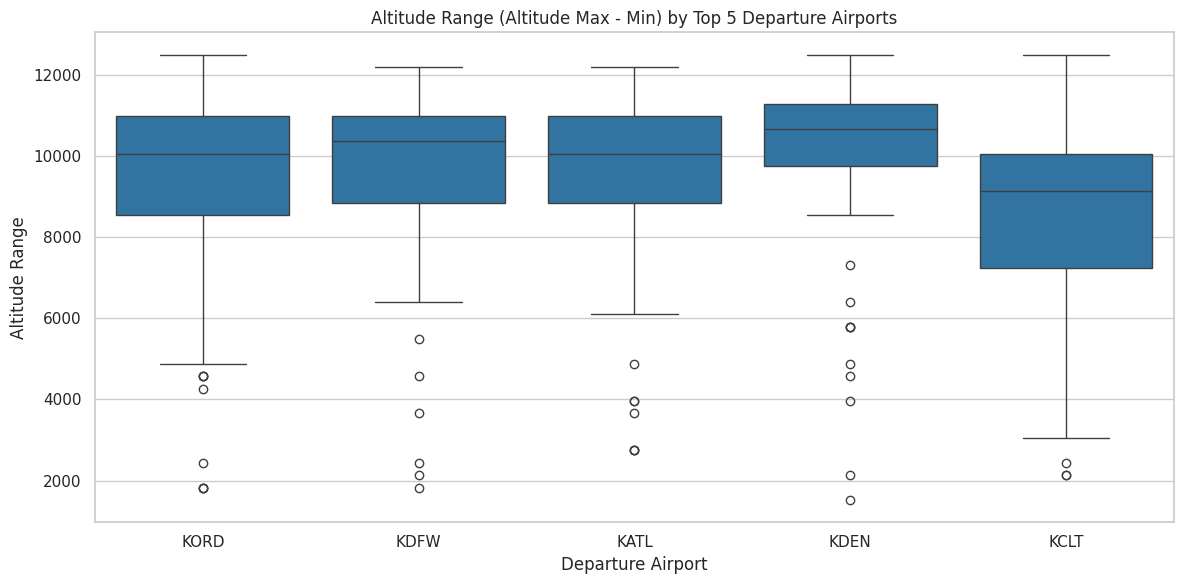

In [16]:
# Altitude Range by Departure Airport

# Create a new column for the altitude range if not already existing.
sample_flights['altitude_range'] = sample_flights['altitude_max'] - sample_flights['altitude_min']

# Identify the top 5 departure airports (by count)
top_dep_airports_alt = sample_flights['estdepartureairport'].value_counts().head(5).index.tolist()

# Filter the data for these top departure airports
alt_top_airports = sample_flights[sample_flights['estdepartureairport'].isin(top_dep_airports_alt)]

plt.figure(figsize=(12, 6))
sns.boxplot(x='estdepartureairport', y='altitude_range', data=alt_top_airports)
plt.title('Altitude Range (Altitude Max - Min) by Top 5 Departure Airports')
plt.xlabel('Departure Airport')
plt.ylabel('Altitude Range')
plt.tight_layout()
plt.show()

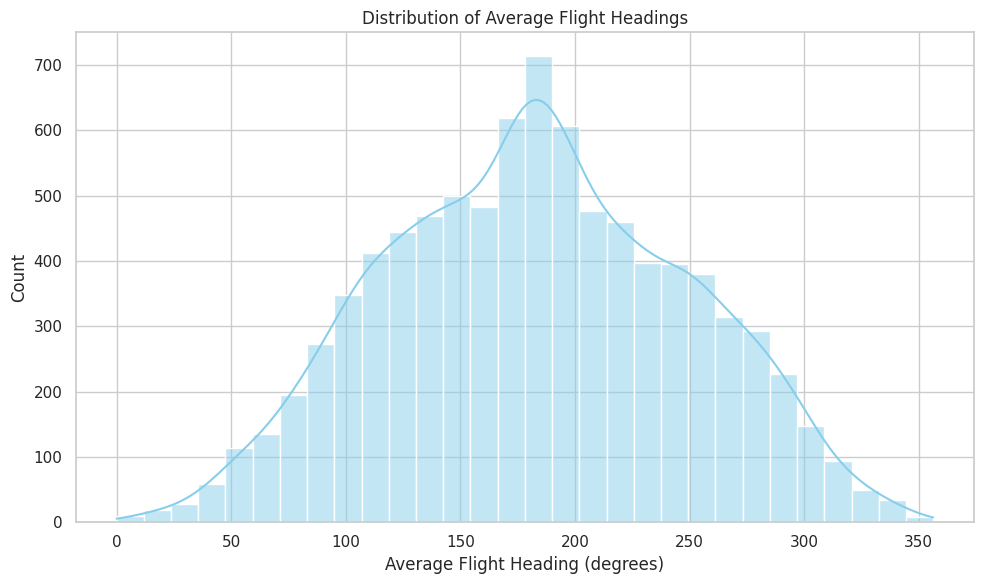

In [17]:
# Overall Distribution of Average Flight Headings

plt.figure(figsize=(10, 6))
# Drop NaN values for heading_avg if there are any
sns.histplot(sample_flights['heading_avg'].dropna(), bins=30, kde=True, color='skyblue')
plt.title('Distribution of Average Flight Headings')
plt.xlabel('Average Flight Heading (degrees)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

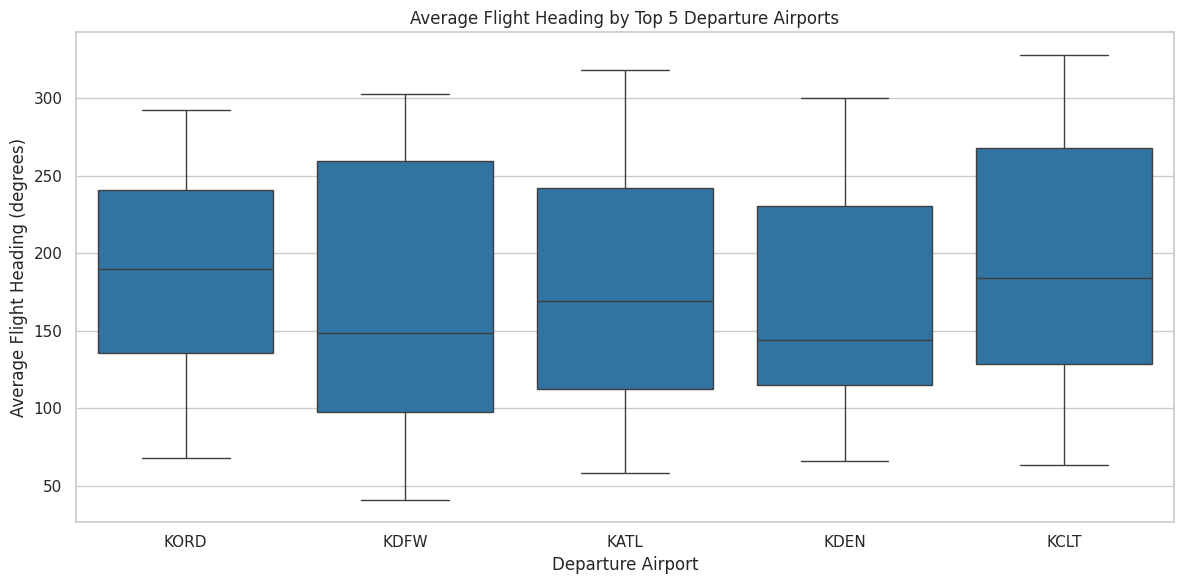

In [18]:
# Compare Average Flight Heading by Top 5 Departure Airports
top_dep_airports_heading = sample_flights['estdepartureairport'].value_counts().head(5).index.tolist()
heading_top_airports = sample_flights[sample_flights['estdepartureairport'].isin(top_dep_airports_heading)]

plt.figure(figsize=(12, 6))
sns.boxplot(x='estdepartureairport', y='heading_avg', data=heading_top_airports)
plt.title('Average Flight Heading by Top 5 Departure Airports')
plt.xlabel('Departure Airport')
plt.ylabel('Average Flight Heading (degrees)')
plt.tight_layout()
plt.show()

### Onground Percentage

- Distribution of onground_percentage: do most flights have a small onground percentage, or is there a large variance?

Summary Statistics for On-ground Percentage:
count    9925.000000
mean        0.159622
std         2.086817
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       100.000000
Name: onground_percentage, dtype: float64

Skewness: 22.885476421695188

Mean On-ground Percentage: 0.15962163040727045


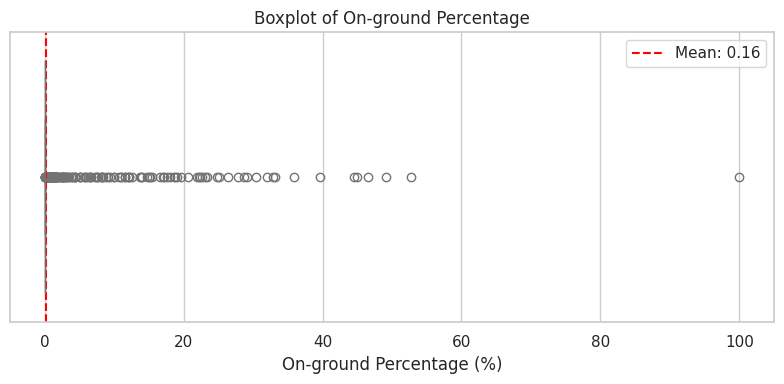

In [19]:
# Onground Percentage Analysis

# Compute and print summary statistics for the onground_percentage column
print("Summary Statistics for On-ground Percentage:")
stats = sample_flights['onground_percentage'].describe()
print(stats)

# Optionally, print the skewness to better understand the distribution asymmetry
skewness = sample_flights['onground_percentage'].skew()
print("\nSkewness:", skewness)

# Calculate the mean onground percentage and print it
mean_onground = sample_flights['onground_percentage'].mean()
print("\nMean On-ground Percentage:", mean_onground)

# Plot the boxplot to better highlight any potential outliers in onground_percentage
plt.figure(figsize=(8,4))
ax = sns.boxplot(x=sample_flights['onground_percentage'], color='lightgreen')
plt.title('Boxplot of On-ground Percentage')
plt.xlabel('On-ground Percentage (%)')

# Mark the mean on the boxplot using a red dashed vertical line
plt.axvline(mean_onground, color='red', linestyle='--', label=f'Mean: {mean_onground:.2f}')
plt.legend()

plt.tight_layout()
plt.show()

## 3. Time-Series and Temporal Analyses


### Flight Traffic Over Time

- Plot the number of flights (by day/week/month) based on start_time or firstseen.
- Identify seasonal trends or peak hours (hour-of-day distribution, day-of-week distribution).


/tmp/ipykernel_346692/2279978915.py:13: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  sample_flights['flight_week'] = sample_flights['local_time'].dt.to_period('W').apply(lambda r: r.start_time)
/tmp/ipykernel_346692/2279978915.py:14: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  sample_flights['flight_month'] = sample_flights['local_time'].dt.to_period('M').apply(lambda r: r.start_time)


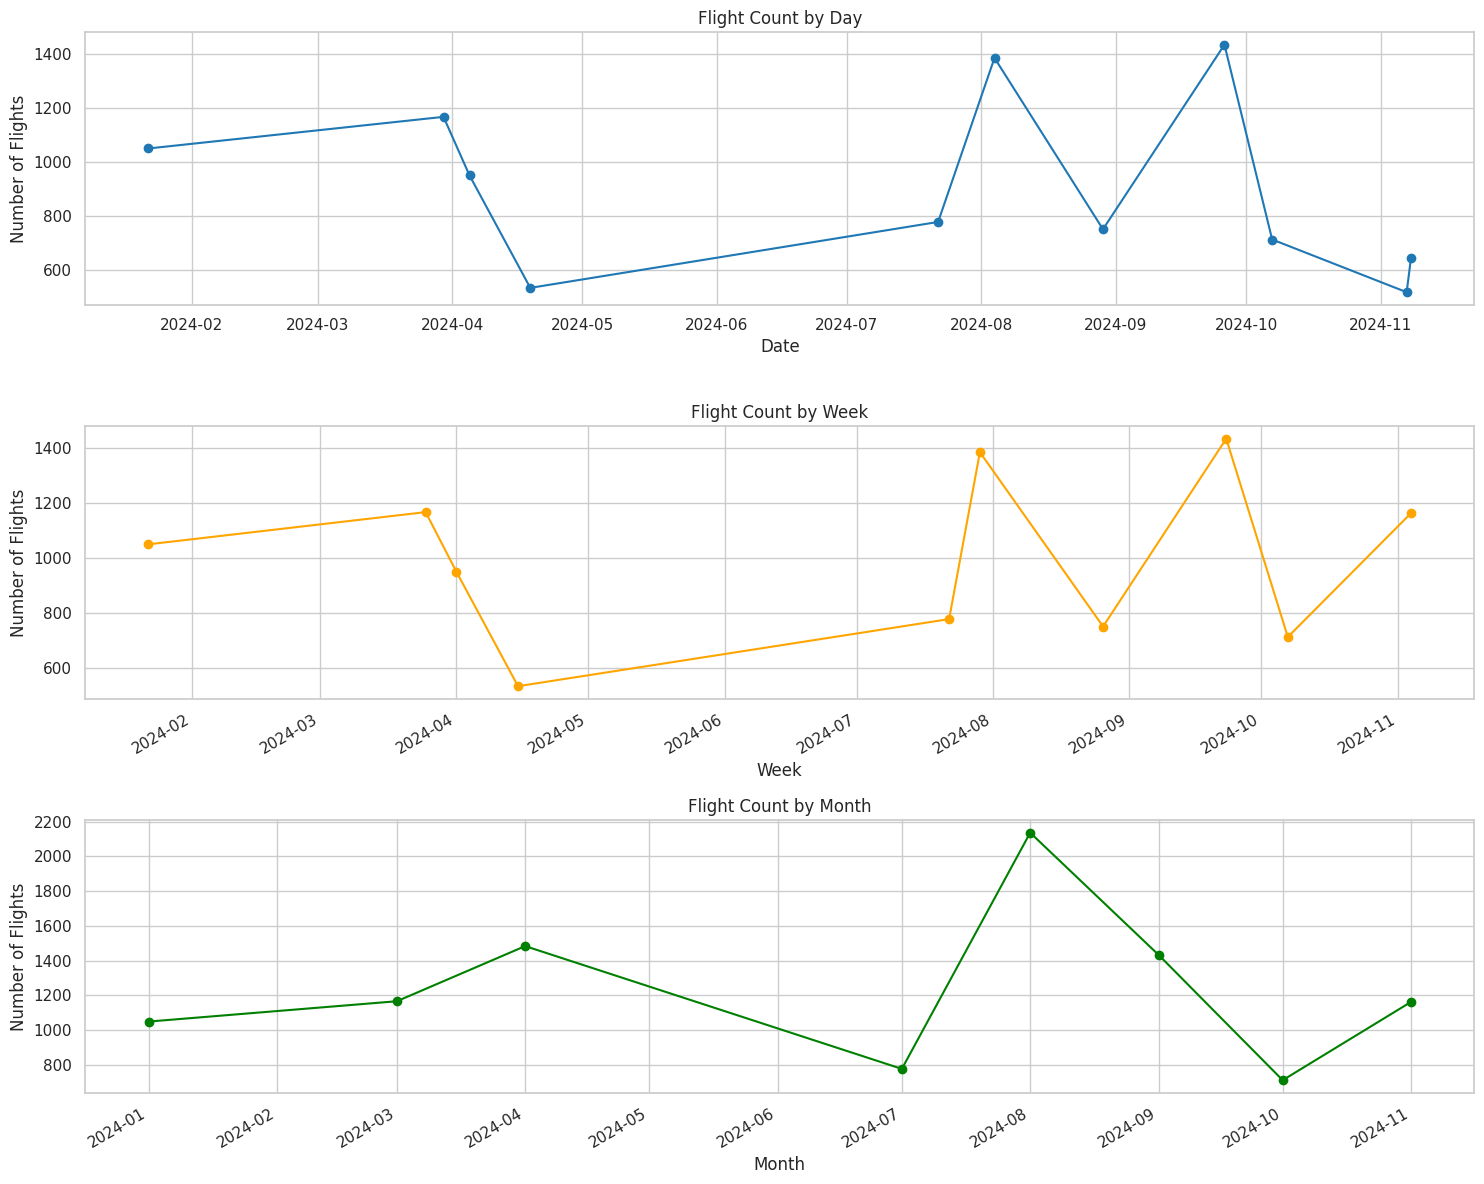

In [20]:
# Flight Traffic Over Time Analysis

# Ensure we have a datetime version of the flight start time. In this example, we create
# a new column 'local_time' based on the 'time_min' column (assuming the timestamp is in seconds)
if 'local_time' not in sample_flights.columns:
    sample_flights['local_time'] = pd.to_datetime(sample_flights['time_min'], unit='s').dt.tz_localize('UTC')

# Create additional columns for aggregation:
# - flight_date: For daily counts
# - flight_week: For weekly counts (using the week’s starting date)
# - flight_month: For monthly counts (using the first day of the month)
sample_flights['flight_date'] = sample_flights['local_time'].dt.date
sample_flights['flight_week'] = sample_flights['local_time'].dt.to_period('W').apply(lambda r: r.start_time)
sample_flights['flight_month'] = sample_flights['local_time'].dt.to_period('M').apply(lambda r: r.start_time)

# Aggregate flight counts for day, week, and month
daily_counts = sample_flights.groupby('flight_date').size()
weekly_counts = sample_flights.groupby('flight_week').size()
monthly_counts = sample_flights.groupby('flight_month').size()

# Plot the flight count over time with subplots for daily, weekly, and monthly aggregation.
plt.figure(figsize=(15, 12))

plt.subplot(3, 1, 1)
daily_counts.plot(kind='line', marker='o')
plt.title('Flight Count by Day')
plt.xlabel('Date')
plt.ylabel('Number of Flights')

plt.subplot(3, 1, 2)
weekly_counts.plot(kind='line', marker='o', color='orange')
plt.title('Flight Count by Week')
plt.xlabel('Week')
plt.ylabel('Number of Flights')

plt.subplot(3, 1, 3)
monthly_counts.plot(kind='line', marker='o', color='green')
plt.title('Flight Count by Month')
plt.xlabel('Month')
plt.ylabel('Number of Flights')

plt.tight_layout()
plt.show()


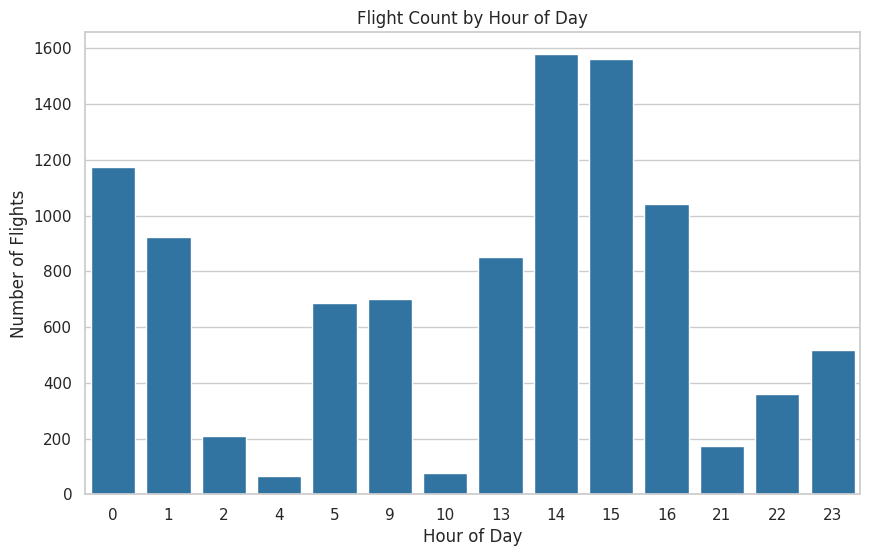

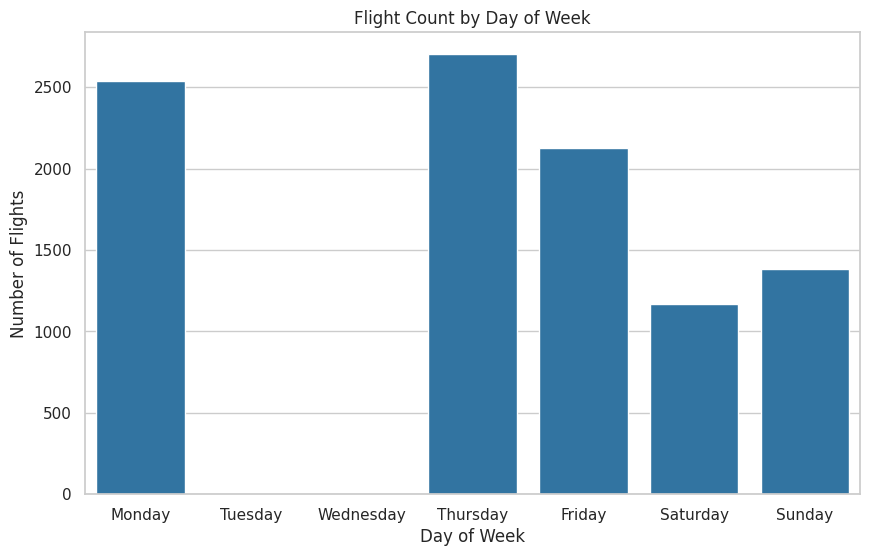

In [21]:

# Seasonal Trends: Analyzing flight counts by hour-of-day and day-of-week

# Extract hour-of-day and day-of-week name from local_time
sample_flights['hour'] = sample_flights['local_time'].dt.hour
sample_flights['day_of_week'] = sample_flights['local_time'].dt.day_name()

# Plot flight count by hour of day
plt.figure(figsize=(10, 6))
sns.countplot(data=sample_flights, x='hour')
plt.title('Flight Count by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Flights')
plt.show()

# Plot flight count by day of week with a specified order
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
plt.figure(figsize=(10, 6))
sns.countplot(data=sample_flights, x='day_of_week', order=order)
plt.title('Flight Count by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Number of Flights')
plt.show()

In [23]:
# Ensure departure and arrival times are in datetime format.
# Here we assume that 'time_min' represents the departure timestamp
# and 'time_max' represents the arrival timestamp (both in seconds).
if 'departure_time' not in sample_flights.columns:
    sample_flights['departure_time'] = pd.to_datetime(sample_flights['time_min'], unit='s', utc=True)
    
if 'arrival_time' not in sample_flights.columns:
    sample_flights['arrival_time'] = pd.to_datetime(sample_flights['time_max'], unit='s', utc=True)


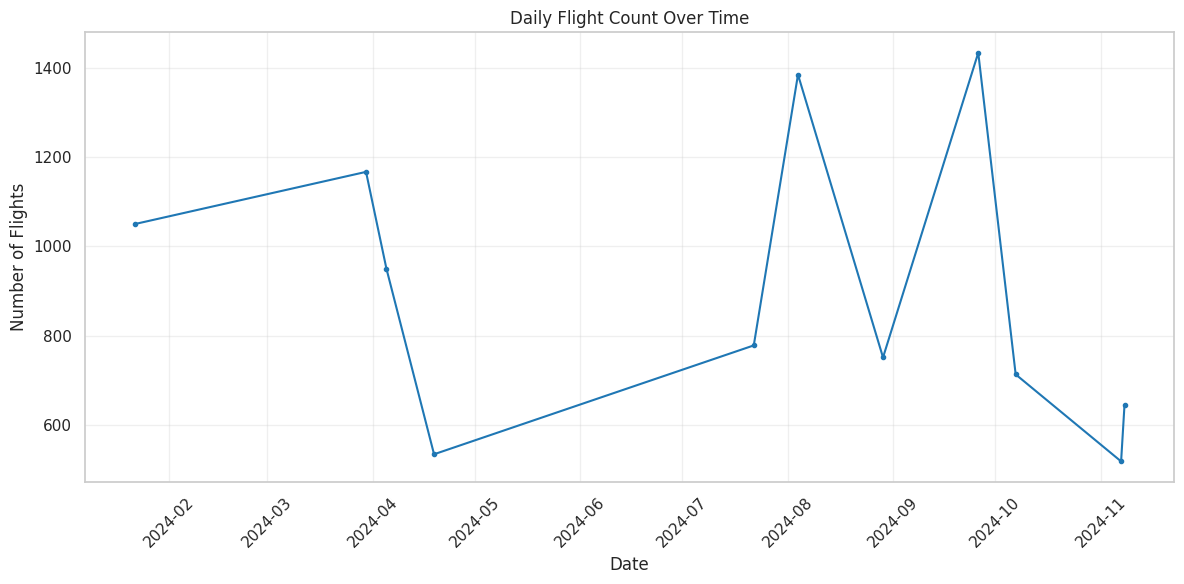

In [24]:
# Plot sample flights by date over the past year
plt.figure(figsize=(12, 6))

# Create daily flight counts
daily_counts = sample_flights['departure_time'].dt.date.value_counts().sort_index()

# Plot the time series
plt.plot(daily_counts.index, daily_counts.values, marker='o', markersize=3)
plt.title('Daily Flight Count Over Time')
plt.xlabel('Date') 
plt.ylabel('Number of Flights')
plt.grid(True, alpha=0.3)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


### Arrival vs Departure Times

- Compare arrival times and departure times to see if there is a peak departure window, rush hour, etc.


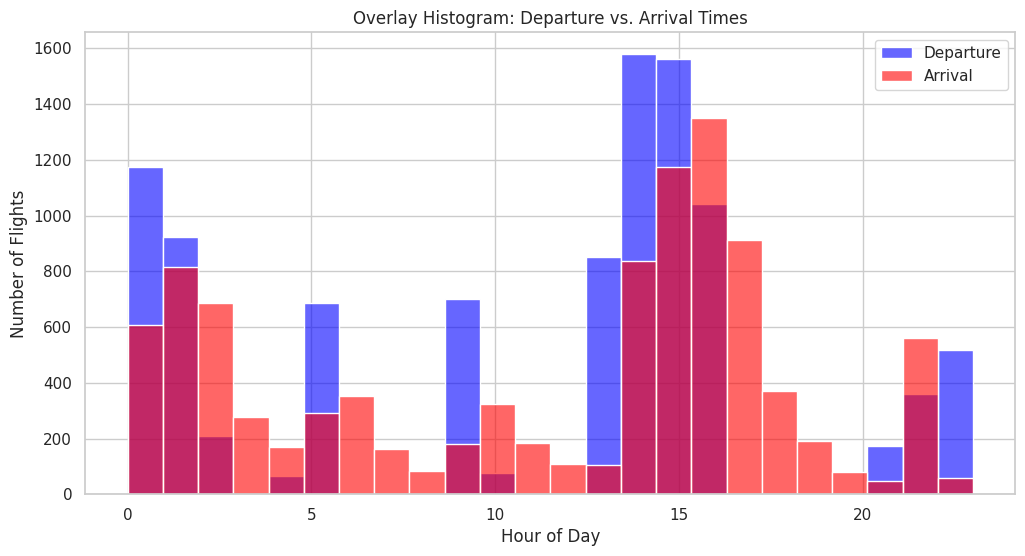

In [25]:

# Extract the hour-of-day for both departure and arrival times.
sample_flights['dep_hour'] = sample_flights['departure_time'].dt.hour
sample_flights['arr_hour'] = sample_flights['arrival_time'].dt.hour

# Create an overlay histogram to compare departure and arrival hour distributions.
plt.figure(figsize=(12, 6))
sns.histplot(sample_flights['dep_hour'], bins=24, color='blue', label='Departure', alpha=0.6)
sns.histplot(sample_flights['arr_hour'], bins=24, color='red', label='Arrival', alpha=0.6)
plt.xlabel("Hour of Day")
plt.ylabel("Number of Flights")
plt.title("Overlay Histogram: Departure vs. Arrival Times")
plt.legend()
plt.show()


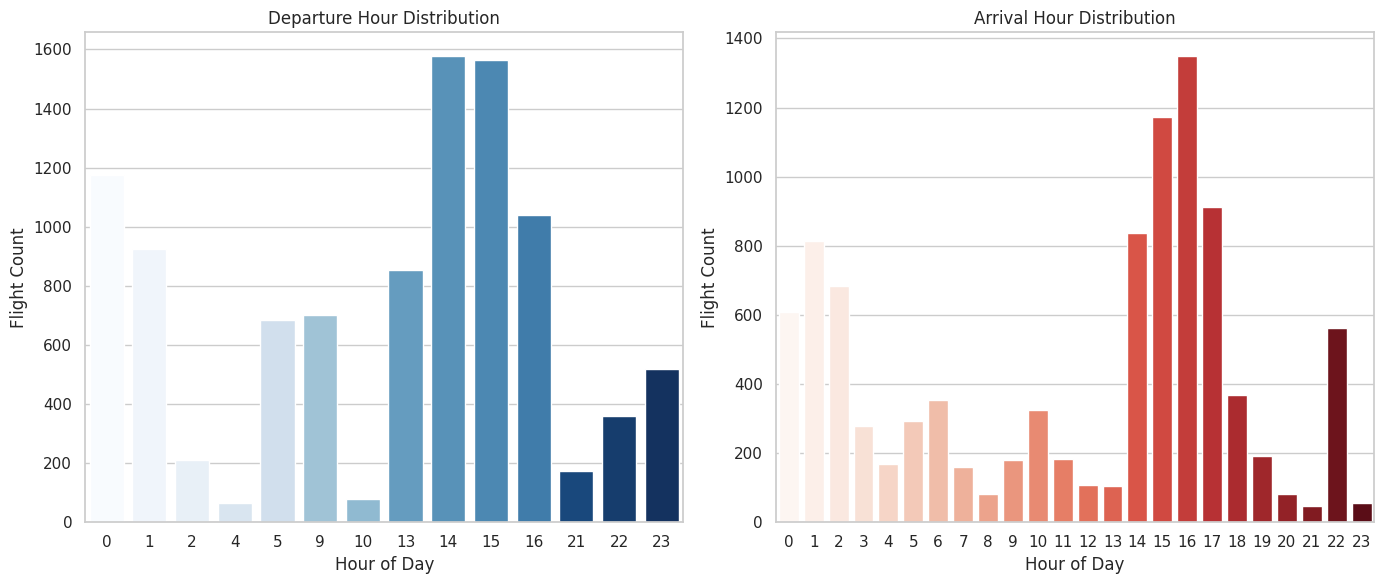

In [26]:
# Alternatively, plot side-by-side count plots for a clearer comparison.
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.countplot(x='dep_hour', data=sample_flights, hue='dep_hour', palette='Blues', legend=False)
plt.title("Departure Hour Distribution")
plt.xlabel("Hour of Day")
plt.ylabel("Flight Count")

plt.subplot(1, 2, 2)
sns.countplot(x='arr_hour', data=sample_flights, hue='arr_hour', palette='Reds', legend=False)
plt.title("Arrival Hour Distribution")
plt.xlabel("Hour of Day")
plt.ylabel("Flight Count")

plt.tight_layout()
plt.show()


### Flight Duration Evolution

- If possible, track how average flight duration changes over days or months.

In [27]:
# Ensure that local_time is defined. If not, create it using the time_min column.
if 'local_time' not in sample_flights.columns:
    sample_flights['local_time'] = pd.to_datetime(sample_flights['time_min'], unit='s', utc=True)

# Ensure flight_duration is computed (in seconds). In case it hasn't been computed already.
if 'flight_duration' not in sample_flights.columns:
    sample_flights['flight_duration'] = sample_flights['time_max'] - sample_flights['time_min']


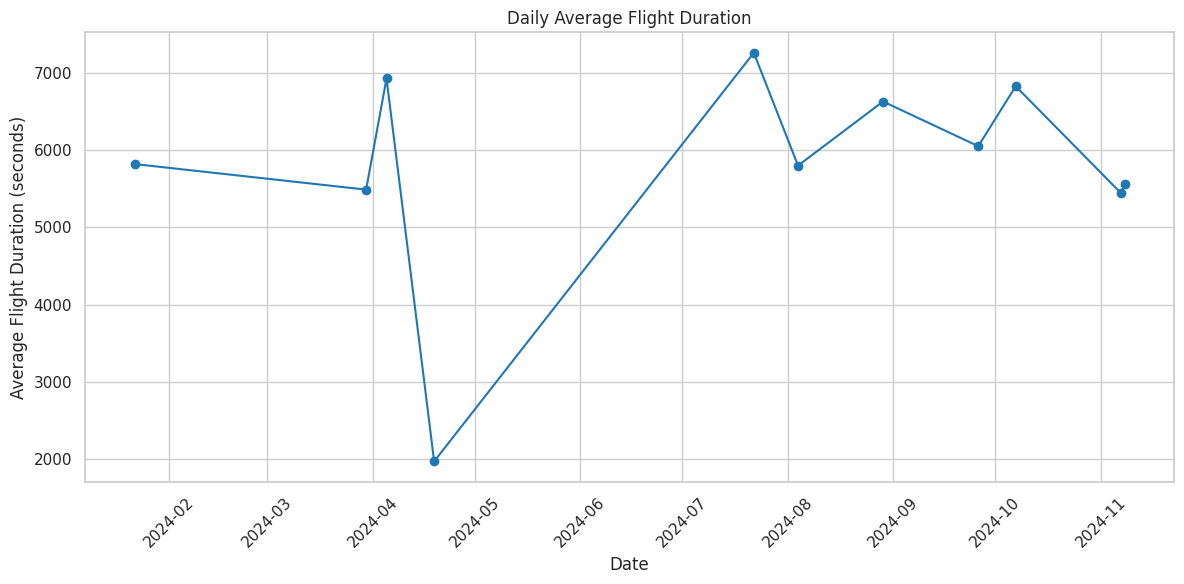

In [28]:

# --- Daily Average Flight Duration Evolution ---

# Create a date column (without time) from the local_time column.
sample_flights['flight_date'] = sample_flights['local_time'].dt.date

# Group by date and calculate the mean flight duration for each day.
daily_avg_duration = sample_flights.groupby('flight_date')['flight_duration'].mean()

# Plot the daily evolution of average flight duration.
plt.figure(figsize=(12, 6))
daily_avg_duration.plot(kind='line', marker='o')
plt.title('Daily Average Flight Duration')
plt.xlabel('Date')
plt.ylabel('Average Flight Duration (seconds)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## 4. Geospatial Visualizations


### Mapping Flight Paths

- Plot flight paths on a map (using latitude_min/max/longitude_min/max or intermediate points if available).

A typical approach:
- Use latitude_avg and longitude_avg as an approximate flight location or mid-point, or
- Plot min-to-max bounding boxes for each flight (though bounding boxes can be rough).


In [29]:
import folium
import pandas as pd

# Optionally, sample a subset of flights for mapping (e.g., 100 rows) to avoid performance issues.
sample_mapped = sample_flights.sample(n=100, random_state=42)

# Compute map center using the average latitude and longitude from the full dataframe.
center_lat = sample_flights['latitude_avg'].mean()
center_lon = sample_flights['longitude_avg'].mean()

# Create a base Folium map.
flight_map = folium.Map(location=[center_lat, center_lon], zoom_start=3)

# Plot the midpoints of flights with a blue circle marker.
for idx, row in sample_mapped.iterrows():
    lat = row['latitude_avg']
    lon = row['longitude_avg']
    # Prepare a short info string to display when marker is clicked.
    popup_text = (
        f"Callsign: {row['callsign']}<br>"
        f"Departure: {row['estdepartureairport']}<br>"
        f"Arrival: {row['estarrivalairport']}"
    )
    folium.CircleMarker(
        location=[lat, lon],
        radius=3,
        popup=folium.Popup(popup_text, max_width=200),
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7
    ).add_to(flight_map)

# Overlay the bounding boxes (min-to-max lat/lon) for each flight.
for idx, row in sample_mapped.iterrows():
    # Check if all required bounding box values are available.
    if all(pd.notnull(row.get(key)) for key in ['latitude_min', 'latitude_max', 'longitude_min', 'longitude_max']):
        # Define the rectangle corners.
        bounds = [
            [row['latitude_min'], row['longitude_min']],
            [row['latitude_min'], row['longitude_max']],
            [row['latitude_max'], row['longitude_max']],
            [row['latitude_max'], row['longitude_min']],
            [row['latitude_min'], row['longitude_min']]  # closing the loop
        ]
        folium.PolyLine(bounds, color='red', weight=1, opacity=0.6).add_to(flight_map)

# Display the map. In a Jupyter Notebook, the map will render inline.
flight_map


### Airport Locations

- We need to find lat/lon for the airports first, map them and label them with flight counts.


### Choropleth or Density Maps

- Heatmap of flight density by region (using latitude_avg, longitude_avg).
- Identify hotspots where flights converge (major hubs).

In [30]:
# Choropleth/Density Map: Heatmap of Flight Density
import folium
from folium.plugins import HeatMap

# Filter out rows with missing latitude or longitude values.
heat_data = sample_flights.dropna(subset=['latitude_avg', 'longitude_avg'])

# Extract the latitude and longitude as a list of [lat, lon] pairs.
heat_points = heat_data[['latitude_avg', 'longitude_avg']].values.tolist()

# Calculate a center for the base map using the average latitude and longitude.
center_lat = sample_flights['latitude_avg'].mean()
center_lon = sample_flights['longitude_avg'].mean()

# Create a base Folium map centered on the computed mean latitude and longitude.
density_map = folium.Map(location=[center_lat, center_lon], zoom_start=3)

# Add a heatmap layer to the map.
# You can adjust the radius (controls the size of the points) and blur (smooths the gradient) as needed.
HeatMap(heat_points, radius=10, blur=15, max_zoom=1).add_to(density_map)

# Display the map (in a Jupyter Notebook the map will render inline)
density_map

## 5. Pairwise Relationships & Correlations


### Pairwise Plots (Scatter Matrix)

- Pairwise comparisons of numeric columns (altitude_avg, heading_avg, onground_percentage, etc.)
- Look for interesting relationships (e.g., correlation between altitude_avg and heading_avg, or between onground_percentage and flight duration if you compute it).


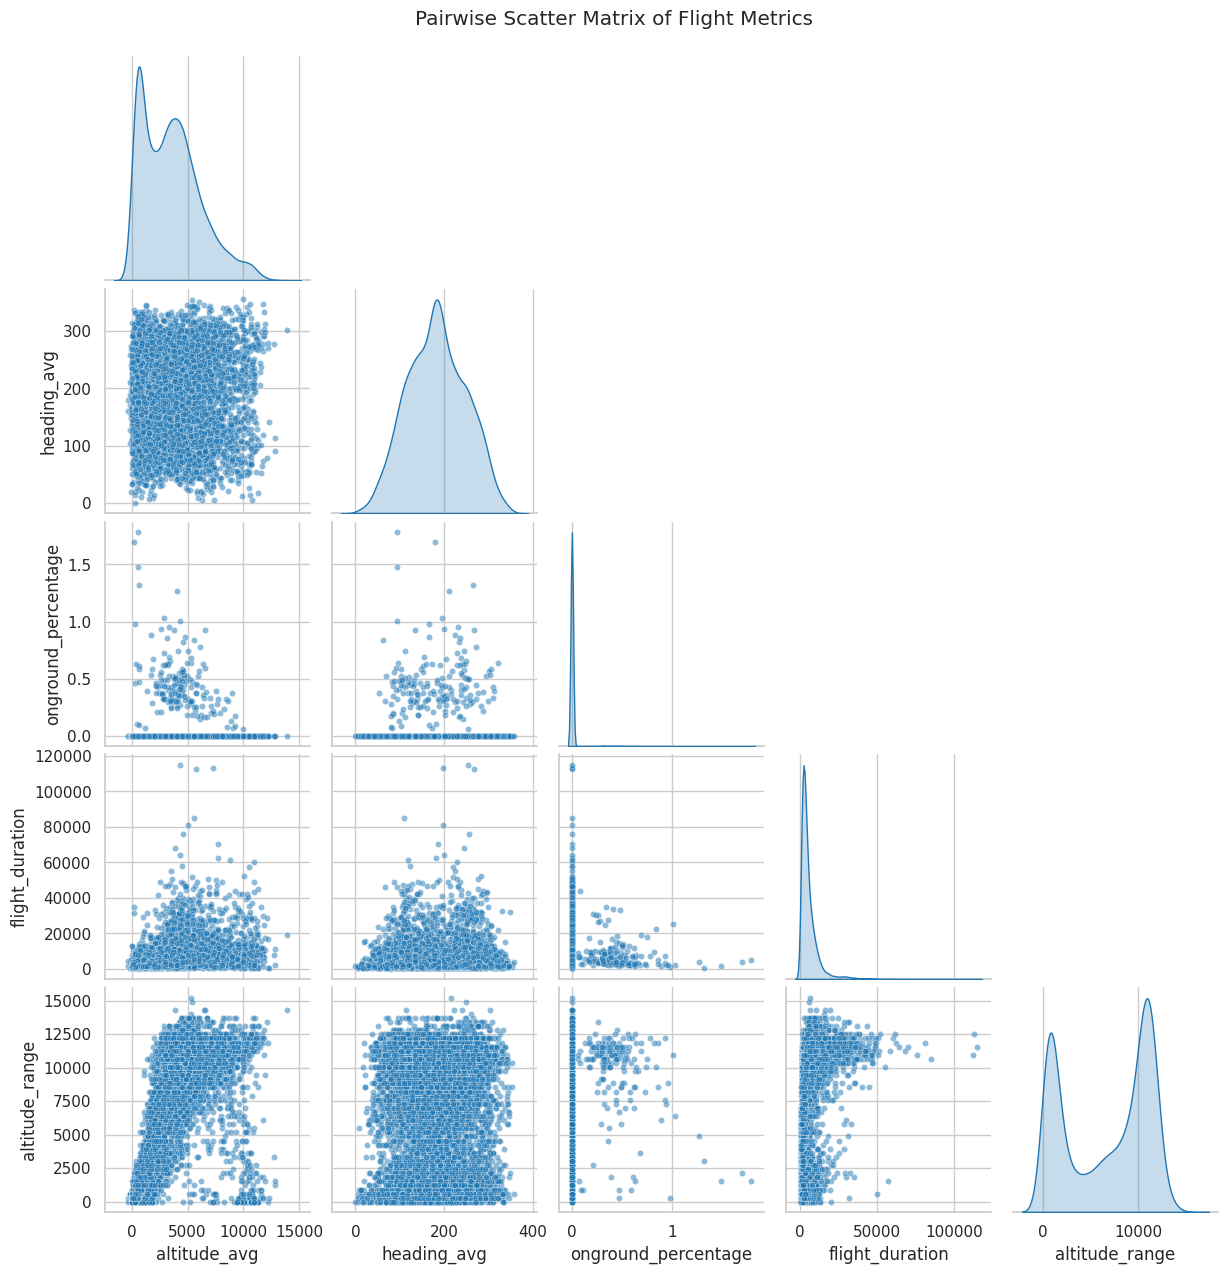

In [31]:
# Define the numeric columns of interest.
# Feel free to add/remove columns based on your analysis focus.
numeric_cols = ['altitude_avg', 'heading_avg', 'onground_percentage', 
                'flight_duration', 'altitude_range']

# Drop rows with missing values for these selected columns to ensure a clean pairplot.
pairwise_data = sample_flights[numeric_cols].dropna()

# Create the pairwise scatter matrix.
sns.pairplot(pairwise_data,
             diag_kind="kde",  # Use KDE plots on the diagonal
             corner=True,      # Only plot the lower triangle for clarity
             plot_kws={"alpha": 0.5, "s": 20},   # Adjust marker transparency and size
             diag_kws={"fill": True})           # Fill the KDE plots (replacing deprecated 'shade')

plt.suptitle('Pairwise Scatter Matrix of Flight Metrics', y=1.02)
plt.show()


### Correlation Heatmap

- Create a correlation matrix for all continuous variables (latitude, longitude, altitude, heading, onground_percentage, etc.).
- Identify any strong positive/negative correlations.

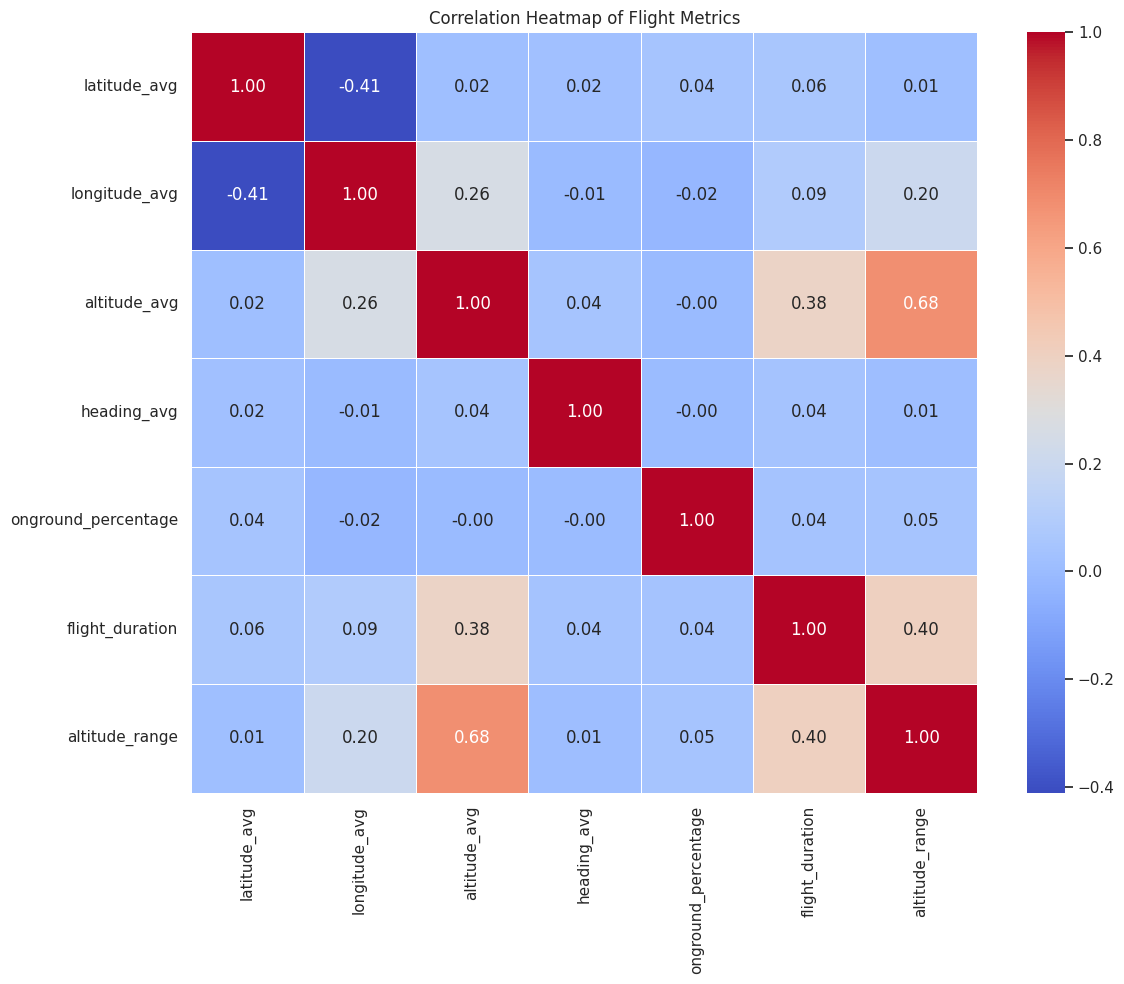

In [32]:
# Define the continuous numeric columns for correlation analysis.
continuous_cols = [
    'latitude_avg', 
    'longitude_avg', 
    'altitude_avg', 
    'heading_avg', 
    'onground_percentage', 
    'flight_duration', 
    'altitude_range'
]

# Compute the correlation matrix for the selected columns.
corr_matrix = sample_flights[continuous_cols].corr()

# Set up the matplotlib figure.
plt.figure(figsize=(12, 10))

# Generate a heatmap with annotations.
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Flight Metrics")
plt.tight_layout()
plt.show()

## 6. Grouped Analyses

### Group by Callsign

- Identify which callsigns appear most frequently.
- Summarize average flight distance, flight altitude, etc., by callsign (potentially interesting if certain airlines or planes have unique patterns).

### Group by Airport Pairs

- Examine all flights from one estdepartureairport to a particular estarrivalairport.
- Check average or median altitude and heading distributions for certain routes.
- Identify the busiest route pairs.

### Time-of-Day vs. On-Ground Percentage

- Check if late-night flights have longer ground times or different patterns.

# Accident flights

In [33]:
import glob

accident_flights = glob.glob("../../data/raw/accident_flights_2/*.parquet")
accident_flights_df = pd.concat([pd.read_parquet(file) for file in accident_flights])


# Convert numeric timestamps to datetime (assuming they're UNIX timestamps in seconds)
accident_flights_df['firstseen_dt'] = pd.to_datetime(
    accident_flights_df['firstseen'], unit='s', origin='unix', utc=True
)
accident_flights_df['lastseen_dt'] = pd.to_datetime(
    accident_flights_df['lastseen'], unit='s', origin='unix', utc=True
)

accident_flights_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 19002 entries, 0 to 523
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   icao24               19002 non-null  string             
 1   callsign             18996 non-null  string             
 2   estdepartureairport  16872 non-null  string             
 3   estarrivalairport    17962 non-null  string             
 4   firstseen            19002 non-null  int64[pyarrow]     
 5   lastseen             19002 non-null  int64[pyarrow]     
 6   track                19002 non-null  object             
 7   firstseen_dt         19002 non-null  datetime64[ns, UTC]
 8   lastseen_dt          19002 non-null  datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](2), int64[pyarrow](2), object(1), string(4)
memory usage: 1.8+ MB


In [34]:

accident_flights_df.head()


,icao24,callsign,estdepartureairport,estarrivalairport,firstseen,lastseen,track,firstseen_dt,lastseen_dt
0,a9e6ea,N737VC,KHWO,KHWO,1705153962,1705154934,"[[1705154932.0, 25.9868557170286, -80.22945697...",2024-01-13 13:52:42+00:00,2024-01-13 14:08:54+00:00
1,a69aaa,N52436,KGEU,19AZ,1705158667,1705161569,"[[1705161564.0, 34.61054992675781, -111.877759...",2024-01-13 15:11:07+00:00,2024-01-13 15:59:29+00:00
2,a9e6ea,N737VC,KHWO,KFLL,1705159833,1705161758,"[[1705161748.0, 25.9654541015625, -80.13147893...",2024-01-13 15:30:33+00:00,2024-01-13 16:02:38+00:00
3,a37279,EPI385,KOCF,KOCF,1705160150,1705161534,"[[1705161530.0, 29.14388882911811, -82.2228644...",2024-01-13 15:35:50+00:00,2024-01-13 15:58:54+00:00
4,a37279,EPI385,KOCF,KOCF,1705165146,1705167055,"[[1705167054.0, 29.145518157441735, -82.222918...",2024-01-13 16:59:06+00:00,2024-01-13 17:30:55+00:00


In [35]:

# find the min and max timestamps in human format 
accident_flights_df['firstseen'].min()
accident_flights_df['firstseen'].max()
# convert to human readable format
print("First seen:", pd.to_datetime(accident_flights_df['firstseen'].min(), unit='s'))
print("Last seen:", pd.to_datetime(accident_flights_df['firstseen'].max(), unit='s'))

First seen: 2020-01-01 14:11:33
Last seen: 2025-01-25 13:21:07


In [36]:
import pandas as pd

# Read the CSV of accident icao24 & date
accidents_df = pd.read_csv("../../data/accident_icao24_dates.csv")

# Rename second column to something more convenient, e.g. 'accident_time'
accidents_df.columns = ['icao24', 'accident_time']

# Convert accident_time string to datetime
accidents_df['accident_time'] = pd.to_datetime(accidents_df['accident_time']).dt.tz_convert('UTC')

# filter by date
accidents_df = accidents_df[accidents_df['accident_time'] >= pd.Timestamp('2019-01-01', tz='UTC')]



In [37]:
accidents_df

,icao24,accident_time
3511,a22fd0,2019-01-02 12:30:00+00:00
3512,a05af3,2019-01-02 12:40:00+00:00
3513,a61e22,2019-01-02 17:50:00+00:00
3514,ab0061,2019-01-03 14:12:00+00:00
3515,ac47f0,2019-01-03 16:25:00+00:00
...,...,...
9558,a67024,2025-01-27 10:30:00+00:00
9559,a127ef,2025-01-27 16:47:00+00:00
9560,aa0b4d,2025-01-30 16:30:00+00:00
9561,ac1c7b,2025-02-01 14:50:00+00:00


In [38]:
merged_df = pd.merge(
    accident_flights_df,
    accidents_df,
    on='icao24',      # join column
    how='inner'       # or 'left', but 'inner' typically is what you want
)

merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19589 entries, 0 to 19588
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   icao24               19589 non-null  object             
 1   callsign             19583 non-null  string             
 2   estdepartureairport  17397 non-null  string             
 3   estarrivalairport    18515 non-null  string             
 4   firstseen            19589 non-null  int64[pyarrow]     
 5   lastseen             19589 non-null  int64[pyarrow]     
 6   track                19589 non-null  object             
 7   firstseen_dt         19589 non-null  datetime64[ns, UTC]
 8   lastseen_dt          19589 non-null  datetime64[ns, UTC]
 9   accident_time        19589 non-null  datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](3), int64[pyarrow](2), object(2), string(3)
memory usage: 1.8+ MB


In [39]:
# Filter for flights where accident time is between firstseen and lastseen
filtered_df = merged_df[
    (merged_df['accident_time'] >= merged_df['firstseen_dt']) & 
    (merged_df['accident_time'] <= merged_df['lastseen_dt'])
]

In [40]:
filtered_df.shape

(191, 10)

In [41]:
filtered_df.head()

,icao24,callsign,estdepartureairport,estarrivalairport,firstseen,lastseen,track,firstseen_dt,lastseen_dt,accident_time
314,a010b3,TMB103,<NA>,39AR,1706462040,1706467389,"[[1706467388.0, 35.39529574119438, -94.2815123...",2024-01-28 17:14:00+00:00,2024-01-28 18:43:09+00:00,2024-01-28 18:23:00+00:00
460,aab001,UAL1890,KLAX,KEWR,1707583404,1707599148,"[[1707599147.0, 40.70635986328125, -74.1560058...",2024-02-10 16:43:24+00:00,2024-02-10 21:05:48+00:00,2024-02-10 17:43:00+00:00
492,a448f5,UAL1494,KSFO,KORD,1655793940,1655806869,"[[1655806868.0, 41.96910095214844, -87.8618483...",2022-06-21 06:45:40+00:00,2022-06-21 10:21:09+00:00,2022-06-21 09:45:00+00:00
628,a5bb14,N469AK,KAFF,KAFF,1656677835,1656681979,"[[1656681977.0, 38.96919250488281, -104.821273...",2022-07-01 12:17:15+00:00,2022-07-01 13:26:19+00:00,2022-07-01 12:25:00+00:00
905,a1e74d,N22111,0NJ6,79OI,1594424425,1594440038,"[[1594440035.0, 39.87794494628906, -83.7735582...",2020-07-10 23:40:25+00:00,2020-07-11 04:00:38+00:00,2020-07-11 00:02:00+00:00


In [42]:
# add parent to path 
import sys
sys.path.append("../../")  # Adjust based on your project structure

from src.transformations.flight_preprocessing import preprocess_flight_data

accident_processed_df = preprocess_flight_data(filtered_df)
accident_processed_df.head()

,icao24,callsign,estdepartureairport,estarrivalairport,firstseen,lastseen,track,firstseen_dt,lastseen_dt,accident_time,...,longitude_min,longitude_max,longitude_avg,altitude_min,altitude_max,altitude_avg,heading_min,heading_max,heading_avg,onground_percentage
314,a010b3,TMB103,<NA>,39AR,1706462040,1706467389,"[[1706467388.0, 35.39529574119438, -94.2815123...",2024-01-28 17:14:00+00:00,2024-01-28 18:43:09+00:00,2024-01-28 18:23:00+00:00,...,-106.772827,-94.281512,-98.951846,914.4,10668.0,6493.933333,85.86081,121.818855,106.968254,0.0
460,aab001,UAL1890,KLAX,KEWR,1707583404,1707599148,"[[1707599147.0, 40.70635986328125, -74.1560058...",2024-02-10 16:43:24+00:00,2024-02-10 21:05:48+00:00,2024-02-10 17:43:00+00:00,...,-118.542312,-74.093295,-95.300582,0.0,11277.6,5038.304416,53.63807,265.213000,137.176945,0.0
492,a448f5,UAL1494,KSFO,KORD,1655793940,1655806869,"[[1655806868.0, 41.96910095214844, -87.8618483...",2022-06-21 06:45:40+00:00,2022-06-21 10:21:09+00:00,2022-06-21 09:45:00+00:00,...,-122.387098,-87.564995,-104.695119,0.0,11277.6,3772.452174,0.00000,359.246150,117.661738,0.0
628,a5bb14,N469AK,KAFF,KAFF,1656677835,1656681979,"[[1656681977.0, 38.96919250488281, -104.821273...",2022-07-01 12:17:15+00:00,2022-07-01 13:26:19+00:00,2022-07-01 12:25:00+00:00,...,-104.928406,-104.819763,-104.857912,1828.8,3048.0,2202.158774,0.00000,359.225770,211.509421,0.0
905,a1e74d,N22111,0NJ6,79OI,1594424425,1594440038,"[[1594440035.0, 39.87794494628906, -83.7735582...",2020-07-10 23:40:25+00:00,2020-07-11 04:00:38+00:00,2020-07-11 00:02:00+00:00,...,-83.773558,-74.657104,-77.737631,609.6,2743.2,1517.623431,186.54630,322.275000,262.167925,0.0


In [43]:
accident_processed_df.query("icao24 == 'a010b3'")

,icao24,callsign,estdepartureairport,estarrivalairport,firstseen,lastseen,track,firstseen_dt,lastseen_dt,accident_time,...,longitude_min,longitude_max,longitude_avg,altitude_min,altitude_max,altitude_avg,heading_min,heading_max,heading_avg,onground_percentage
314,a010b3,TMB103,<NA>,39AR,1706462040,1706467389,"[[1706467388.0, 35.39529574119438, -94.2815123...",2024-01-28 17:14:00+00:00,2024-01-28 18:43:09+00:00,2024-01-28 18:23:00+00:00,...,-106.772827,-94.281512,-98.951846,914.4,10668.0,6493.933333,85.86081,121.818855,106.968254,0.0


In [44]:
accident_processed_df[['firstseen_dt', 'lastseen_dt','start_time', 'end_time', 'accident_time']]

,firstseen_dt,lastseen_dt,start_time,end_time,accident_time
314,2024-01-28 17:14:00+00:00,2024-01-28 18:43:09+00:00,2024-01-28 17:14:00,2024-01-28 18:43:08,2024-01-28 18:23:00+00:00
460,2024-02-10 16:43:24+00:00,2024-02-10 21:05:48+00:00,2024-02-10 16:43:24,2024-02-10 21:05:47,2024-02-10 17:43:00+00:00
492,2022-06-21 06:45:40+00:00,2022-06-21 10:21:09+00:00,2022-06-21 06:45:40,2022-06-21 10:21:08,2022-06-21 09:45:00+00:00
628,2022-07-01 12:17:15+00:00,2022-07-01 13:26:19+00:00,2022-07-01 12:17:15,2022-07-01 13:26:17,2022-07-01 12:25:00+00:00
905,2020-07-10 23:40:25+00:00,2020-07-11 04:00:38+00:00,2020-07-10 23:40:25,2020-07-11 04:00:35,2020-07-11 00:02:00+00:00
...,...,...,...,...,...
18729,2022-03-29 18:15:15+00:00,2022-03-29 19:50:53+00:00,2022-03-29 18:15:15,2022-03-29 19:50:45,2022-03-29 18:45:00+00:00
18891,2020-01-10 22:03:55+00:00,2020-01-11 00:20:16+00:00,2020-01-10 22:03:55,2020-01-11 00:20:11,2020-01-10 23:45:00+00:00
19033,2020-01-24 21:13:27+00:00,2020-01-25 00:47:48+00:00,2020-01-24 21:13:27,2020-01-25 00:47:42,2020-01-24 21:54:00+00:00
19181,2024-03-09 14:33:37+00:00,2024-03-09 16:17:54+00:00,2024-03-09 14:33:37,2024-03-09 16:17:53,2024-03-09 15:31:00+00:00


In [45]:
accident_processed_df.to_parquet("../../data/processed/accident_flights.parquet")

In [47]:
# lets save a version where its only icao and the firstseen and lastseen timestamps
accident_processed_df[['icao24', 'firstseen', 'lastseen', 'accident_time']].to_csv("../../data/accident_flights_icao.csv", index=False)
